<h1>Light Grdient Boosting Classifier<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Log-experiment-to-Neptune.ai" data-toc-modified-id="Log-experiment-to-Neptune.ai-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Log experiment to Neptune.ai</a></span></li><li><span><a href="#Chargement-des-données" data-toc-modified-id="Chargement-des-données-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Chargement des données</a></span></li><li><span><a href="#SPLITTING" data-toc-modified-id="SPLITTING-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>SPLITTING</a></span></li><li><span><a href="#Métique-métier-et-scorer" data-toc-modified-id="Métique-métier-et-scorer-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Métique métier et scorer</a></span><ul class="toc-item"><li><span><a href="#Scores-du-modèles-prédisant-toujours-la-classe-majoritaire" data-toc-modified-id="Scores-du-modèles-prédisant-toujours-la-classe-majoritaire-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Scores du modèles prédisant toujours la classe majoritaire</a></span></li></ul></li><li><span><a href="#LGBM-Classifier" data-toc-modified-id="LGBM-Classifier-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>LGBM Classifier</a></span><ul class="toc-item"><li><span><a href="#Evaluation-du-modéle" data-toc-modified-id="Evaluation-du-modéle-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Evaluation du modéle</a></span></li><li><span><a href="#Etude-des-differentes-options-pour-rétablir-l'équilbre-entre-les-classes" data-toc-modified-id="Etude-des-differentes-options-pour-rétablir-l'équilbre-entre-les-classes-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Etude des differentes options pour rétablir l'équilbre entre les classes</a></span><ul class="toc-item"><li><span><a href="#Pipeline-with-sampling--step" data-toc-modified-id="Pipeline-with-sampling--step-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>Pipeline with sampling  step</a></span><ul class="toc-item"><li><span><a href="#Under-Sampling" data-toc-modified-id="Under-Sampling-6.2.1.1"><span class="toc-item-num">6.2.1.1&nbsp;&nbsp;</span>Under Sampling</a></span></li><li><span><a href="#Over-Sampling" data-toc-modified-id="Over-Sampling-6.2.1.2"><span class="toc-item-num">6.2.1.2&nbsp;&nbsp;</span>Over Sampling</a></span></li><li><span><a href="#Class-Weight-'balanced'" data-toc-modified-id="Class-Weight-'balanced'-6.2.1.3"><span class="toc-item-num">6.2.1.3&nbsp;&nbsp;</span>Class Weight 'balanced'</a></span></li></ul></li><li><span><a href="#Combinaison-des-trois-solutions-précédentes" data-toc-modified-id="Combinaison-des-trois-solutions-précédentes-6.2.2"><span class="toc-item-num">6.2.2&nbsp;&nbsp;</span>Combinaison des trois solutions précédentes</a></span></li></ul></li><li><span><a href="#Recherche-de-la-combinaison-optimale" data-toc-modified-id="Recherche-de-la-combinaison-optimale-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Recherche de la combinaison optimale</a></span></li><li><span><a href="#Meilleure-solution" data-toc-modified-id="Meilleure-solution-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Meilleure solution</a></span></li></ul></li><li><span><a href="#Récapitulatif-des-scores" data-toc-modified-id="Récapitulatif-des-scores-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Récapitulatif des scores</a></span></li><li><span><a href="#Sauvegarde-du-modèle-pour-dasboard" data-toc-modified-id="Sauvegarde-du-modèle-pour-dasboard-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Sauvegarde du modèle pour dasboard</a></span></li></ul></div>

# Imports



In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 
pd.set_option('display.max_row', 244)
pd.set_option('display.max_column', 243)
pd.set_option('display.max_colwidth', 50)

# graphical libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go


# misc libaries
import missingno as msno
bleu = (70 / 255, 130 / 255, 180 / 255)
# import dataprep.eda as eda
import qgrid

# File system manangement
import os
import joblib 

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 1
%aimport Functions
from Functions import plot_confusion_matrix, cv_score,evaluate_estimator, proba_distributions, feature_importance_plot

Loading functions


In [3]:
# CONSTANTS

ITERATIONS = 100

JOBS = 1

EDA = 'EDA 1-7 all features_aggregated'


LOG = True

RESUME = True
ID_RUN = 'PROJ-10'

# Log experiment to Neptune.ai

In [4]:
import neptune.new as neptune
# import neptunecontrib.monitoring.optuna as opt_utils
import neptune.new.integrations.optuna as optuna_utils
from neptune.new.types import File

if LOG:
    NEPTUNE_API_TOKEN="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkOTQ1YmNhNS1hZDYyLTRlYzQtYWU0Zi0xMjY0Yjg1MzBiMzEifQ=="
    # log to Neptune
    if RESUME:
        run = neptune.init(api_token=NEPTUNE_API_TOKEN,
                           project='m.leroy975/Projet07',
                           run=ID_RUN) # your credentials
    else:
        run = neptune.init(api_token=NEPTUNE_API_TOKEN,
                           project='m.leroy975/Projet07') # your credentials
    
    run['sys/tags'].add(EDA)
    run['sys/tags'].add('balanced')

    neptune_callback = optuna_utils.NeptuneCallback(run,
                                                    plots_update_freq=10,
                                                    log_plot_param_importances=True)    

Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/m.leroy975/Projet07/e/PROJ-10
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


# Chargement des données

In [5]:
# local run
path='FEATURES/'
features = joblib.load ( path+EDA+'.feat')

# # Kaggle run
# path='../input/projet-07/' 
# features = joblib.load ( path+EDA+'.feat')

if LOG:
    # Name and hash of experiment features
    run['Data/Version/Features'].log(EDA)
    run['Data/Version/Features hash'].log(pd.util.hash_pandas_object(features))

Vérification du chargement

<AxesSubplot:>

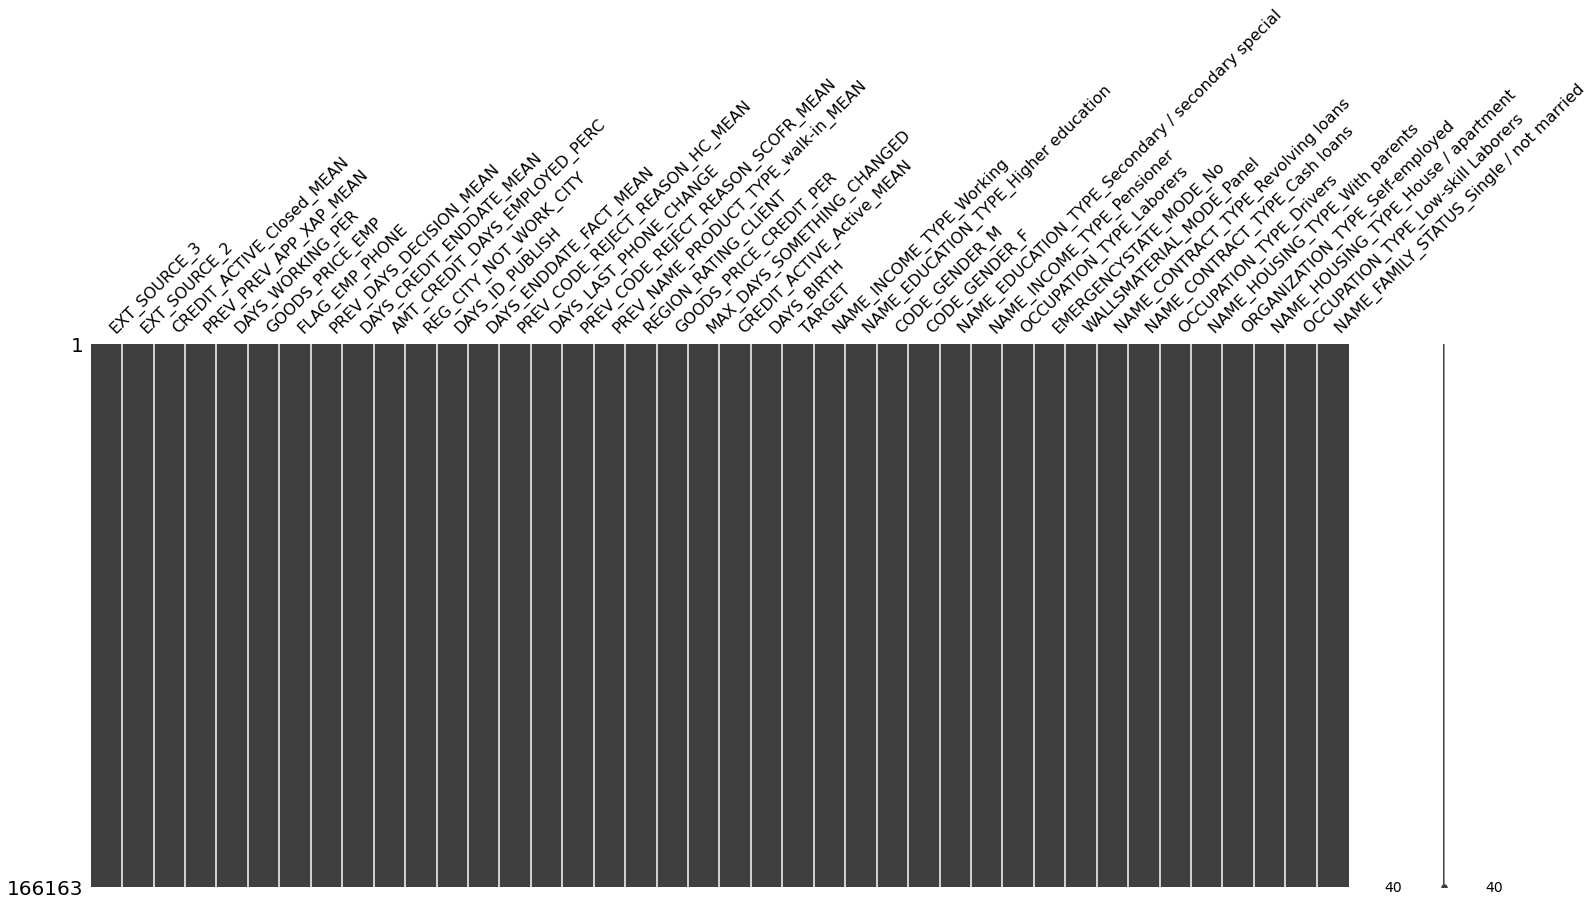

In [6]:
msno.matrix(features)

In [7]:
# Features overwiew
from collections import Counter

display(features)
print('Features shape {} x {}'.format(features.shape[0],features.shape[1]))
# TARGET ration on whole dataset
print('TARGET ratio {:.8%}'.format(features.TARGET.value_counts()[1]/features.TARGET.value_counts()[0]) )
print(Counter(features.TARGET))

,EXT_SOURCE_3,EXT_SOURCE_2,CREDIT_ACTIVE_Closed_MEAN,PREV_PREV_APP_XAP_MEAN,DAYS_WORKING_PER,GOODS_PRICE_EMP,FLAG_EMP_PHONE,PREV_DAYS_DECISION_MEAN,DAYS_CREDIT_ENDDATE_MEAN,AMT_CREDIT_DAYS_EMPLOYED_PERC,REG_CITY_NOT_WORK_CITY,DAYS_ID_PUBLISH,DAYS_ENDDATE_FACT_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,DAYS_LAST_PHONE_CHANGE,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_NAME_PRODUCT_TYPE_walk-in_MEAN,REGION_RATING_CLIENT,GOODS_PRICE_CREDIT_PER,MAX_DAYS_SOMETHING_CHANGED,CREDIT_ACTIVE_Active_MEAN,DAYS_BIRTH,TARGET,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,CODE_GENDER_M,CODE_GENDER_F,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_INCOME_TYPE_Pensioner,OCCUPATION_TYPE_Laborers,EMERGENCYSTATE_MODE_No,WALLSMATERIAL_MODE_Panel,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_Cash loans,OCCUPATION_TYPE_Drivers,NAME_HOUSING_TYPE_With parents,ORGANIZATION_TYPE_Self-employed,NAME_HOUSING_TYPE_House / apartment,OCCUPATION_TYPE_Low-skill Laborers,NAME_FAMILY_STATUS_Single / not married
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,0.139376,0.262949,0.750000,1.00,0.067329,0.001815,1,-606.000000,-349.000000,-0.001567,0,-2120,-697.500000,0.00,-1134.0,0.0,0.00,2,1.158397,-637.0,0.250000,-9461,1,1,0,1,0,1,0,1,1,0,0,1,0,0,0,1,0,1
100004,0.729567,0.555912,1.000000,1.00,0.011814,0.001667,1,-815.000000,-488.500000,-0.001667,0,-2531,-532.500000,0.00,-815.0,0.0,0.00,2,1.000000,-225.0,0.000000,-19046,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,1
100008,0.621226,0.354225,0.666667,1.00,0.093737,0.003494,1,-1192.000000,-391.333333,-0.003238,0,-477,-909.000000,0.00,-2536.0,0.0,0.00,2,1.079198,-477.0,0.333333,-16941,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0
100009,0.492060,0.724000,0.777778,1.00,0.227174,0.002244,1,-719.285714,-794.937500,-0.002005,0,-619,-1108.500000,0.00,-1562.0,0.0,0.00,2,1.118800,-619.0,0.222222,-13778,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
100010,0.540654,0.714279,0.500000,1.00,0.023820,0.000293,1,-1070.000000,-119.500000,-0.000293,1,-2379,-1138.000000,0.00,-1070.0,0.0,0.00,3,1.000000,-449.0,0.500000,-18850,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456246,0.735221,0.313334,0.666667,1.00,0.543859,0.038827,1,-897.000000,-234.666667,-0.038827,1,-4531,-1331.000000,0.00,-1516.0,0.0,0.00,2,1.000000,-4531.0,0.333333,-16063,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0
456247,0.609276,0.501221,0.727273,0.80,0.033614,0.001612,1,-1387.800000,1449.818182,-0.001155,0,-3936,-1085.000000,0.20,-2315.0,0.0,0.00,2,1.396000,-399.0,0.272727,-11870,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1
456253,0.218859,0.535722,0.500000,1.00,0.529266,0.013540,1,-2380.000000,280.500000,-0.011689,1,-5150,-794.000000,0.00,-1909.0,0.0,0.00,3,1.158400,-5150.0,0.500000,-14966,0,1,1,0,1,0,0,0,1,1,0,1,0,0,0,1,0,0


Features shape 166163 x 40
TARGET ratio 8.55218459%
Counter({0: 153072, 1: 13091})


In [8]:
# Descriptive Statistics of features
features.describe()

,EXT_SOURCE_3,EXT_SOURCE_2,CREDIT_ACTIVE_Closed_MEAN,PREV_PREV_APP_XAP_MEAN,DAYS_WORKING_PER,GOODS_PRICE_EMP,FLAG_EMP_PHONE,PREV_DAYS_DECISION_MEAN,DAYS_CREDIT_ENDDATE_MEAN,AMT_CREDIT_DAYS_EMPLOYED_PERC,REG_CITY_NOT_WORK_CITY,DAYS_ID_PUBLISH,DAYS_ENDDATE_FACT_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,DAYS_LAST_PHONE_CHANGE,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_NAME_PRODUCT_TYPE_walk-in_MEAN,REGION_RATING_CLIENT,GOODS_PRICE_CREDIT_PER,MAX_DAYS_SOMETHING_CHANGED,CREDIT_ACTIVE_Active_MEAN,DAYS_BIRTH,TARGET,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,CODE_GENDER_M,CODE_GENDER_F,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_INCOME_TYPE_Pensioner,OCCUPATION_TYPE_Laborers,EMERGENCYSTATE_MODE_No,WALLSMATERIAL_MODE_Panel,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_Cash loans,OCCUPATION_TYPE_Drivers,NAME_HOUSING_TYPE_With parents,ORGANIZATION_TYPE_Self-employed,NAME_HOUSING_TYPE_House / apartment,OCCUPATION_TYPE_Low-skill Laborers,NAME_FAMILY_STATUS_Single / not married
count,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.00000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000
mean,0.510259,0.522641,0.653382,0.862464,0.167314,0.007263,0.999958,-960.526239,530.347564,-0.006515,0.269284,-2930.141831,-948.384656,0.061699,-1068.938759,0.005888,0.081658,2.055151,1.121981,-1432.243454,0.342889,-15032.930021,0.078784,0.634377,0.268225,0.363884,0.636116,0.687837,0.000048,0.217287,0.525767,0.21784,0.093137,0.906863,0.072525,0.052081,0.142926,0.883241,0.006927,0.136553
std,0.194887,0.186316,0.224895,0.197720,0.138020,0.011067,0.006490,568.589438,2591.832795,0.009935,0.443589,1485.695073,512.261883,0.133157,825.088565,0.043194,0.177448,0.499676,0.124815,1181.057628,0.223962,3555.417425,0.269402,0.481606,0.443036,0.481117,0.481117,0.463377,0.006939,0.412401,0.499337,0.41278,0.290626,0.290626,0.259356,0.222192,0.349998,0.321134,0.082940,0.343376
min,0.000527,0.000010,0.000000,0.000000,0.000042,0.000002,0.000000,-2922.000000,-28039.000000,-0.256178,0.000000,-7197.000000,-2884.000000,0.000000,-4173.000000,0.000000,0.000000,1.000000,0.150000,-6226.000000,0.000000,-25200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.370650,0.411550,0.500000,0.750000,0.061776,0.001720,1.000000,-1297.000000,-711.000000,-0.007465,0.000000,-4239.000000,-1269.500000,0.000000,-1684.000000,0.000000,0.000000,2.000000,1.000000,-2094.000000,0.187500,-17721.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.537070,0.573477,0.666667,1.000000,0.130265,0.003899,1.000000,-845.375000,-197.000000,-0.003506,0.000000,-3076.000000,-916.000000,0.000000,-929.000000,0.000000,0.000000,2.000000,1.118800,-1094.000000,0.333333,-14834.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.667458,0.666053,0.800000,1.000000,0.234367,0.008310,1.000000,-512.422619,505.950000,-0.001541,1.000000,-1696.000000,-565.633333,0.000000,-376.000000,0.000000,0.083333,2.000000,1.198000,-495.000000,0.500000,-12168.500000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,0.885488,0.855000,1.000000,1.000000,0.728811,0.256178,1.000000,-2.000000,31186.000000,-0.

# SPLITTING

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(features,
                               test_size=.2,
                               random_state=42,
                               shuffle=True,
                               stratify=features.TARGET)

train_true = train.pop('TARGET')
print('train',train.shape)
print('TARGET=1 ratio on train {:.8%}'.format(train_true.value_counts()[1]/train_true.value_counts()[0]) )
test_true = test.pop('TARGET')
print('test',test.shape)
print('TARGET=1 ratio on test {:.8%}'.format(test_true.value_counts()[1]/test_true.value_counts()[0]) )

train (132930, 39)
TARGET=1 ratio on train 8.55238982%
test (33233, 39)
TARGET=1 ratio on test 8.55136371%


In [10]:
if LOG:
    run['Data/Version/Train shape'].log(str(train.shape))
    run['Data/Version/Train target ratio'].log(train_true.value_counts()[1]/train_true.value_counts()[0])
    run['Data/Version/Test shape'].log(str(test.shape))
    run['Data/Version/Test target ratio'].log(test_true.value_counts()[1]/test_true.value_counts()[0])

# Métique métier et scorer

In [11]:
from sklearn.metrics import  confusion_matrix, make_scorer, roc_auc_score

# Cost weight
tn_cost = 2  ; fn_cost = -5
fp_cost = -6  ; tp_cost = 1

penalty = np.array([tn_cost,fn_cost,fp_cost,tp_cost])

# cost function
def cost(y,y_pred):
    cm = confusion_matrix(y,y_pred,normalize='true')
#     print(cm)

#     return  sum( cm.reshape(-1)*penalty)
    return  (sum( cm.reshape(-1)*penalty)+11)/14

SCORER = {'AUC' : 'roc_auc', 'COST' : make_scorer(cost)}

In [12]:
# Worst score
true =  [0,0,1,1]
preds = [1,1,0,0] 
print('Worst cost score : ',cost(true, preds))
print('Worst roc auc score : ',roc_auc_score(true, preds))

Worst cost score :  0.0
Worst roc auc score :  0.0


In [13]:
# Best score
true =  [0,0,0,1,1,1,1,0,0,0,1,0,1]
preds = [0,0,0,1,1,1,1,0,0,0,1,0,1] 
print('Best cost score : ',cost(true, preds))
print('Best roc auc score : ',roc_auc_score(true, preds))

Best cost score :  1.0
Best roc auc score :  1.0


## Scores du modèles prédisant toujours la classe majoritaire

In [14]:
cost(train_true, [0]*len(train_true))

0.5

In [15]:
roc_auc_score(train_true, [0]*len(train_true))

0.5

# LGBM Classifier

In [16]:
import lightgbm as lgb

MODEL = lgb.LGBMClassifier(random_state=42, n_jobs=-1)
if LOG:
    # Name and hash of experiment features
    run['Modele/Name'] = 'LightGradientBoosting Classifier'
    run['sys/description'] = 'LGBM'

## Evaluation du modéle 

Pipeline : 

    * min max scaler [0;1]
    * modèle
       
Scores sur 5 cross validations    

In [17]:
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

Class balance on fitting model step : Counter({0: 122457, 1: 10473})
TRAIN
               precision    recall  f1-score   support

           0       0.92      1.00      0.96    122457
           1       0.83      0.03      0.05     10473

    accuracy                           0.92    132930
   macro avg       0.87      0.51      0.51    132930
weighted avg       0.92      0.92      0.89    132930

 Scores  on train : {'COST': 0.5067739833369364, 'AUC': 0.7417318955925576}
TEST
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     30615
           1       0.45      0.01      0.02      2618

    accuracy                           0.92     33233
   macro avg       0.69      0.51      0.49     33233
weighted avg       0.88      0.92      0.89     33233

 Scores  on test : {'COST': 0.5052999392265035}


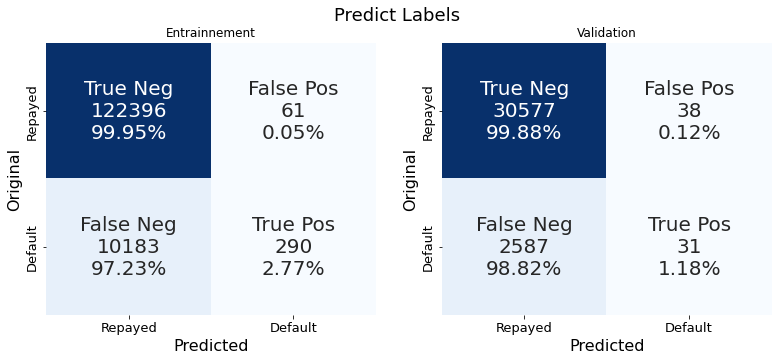

In [18]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler

from imblearn.pipeline import Pipeline 

from collections import Counter


pipe = Pipeline([ 
                 ('scaler' , MinMaxScaler(feature_range=(0, 1))),
                          
                 ('model', MODEL)
                ])

# fit pipeline on train
pipe.fit(train, train_true)

# Count effective classes
print('Class balance on fitting model step : %s' % Counter(train_true))
if LOG:
    run['Modele/[Out of bag]/Classe efectives'] = str(Counter(train_true))
    
# print evaluation summary
evaluate_estimator(pipe,
                   train.values,
                   train_true,
                   test.values,
                   test_true,
                   SCORER,
                   cost,
                   cv,
                   log=(LOG,run,'Modele/[Out of bag]/'))

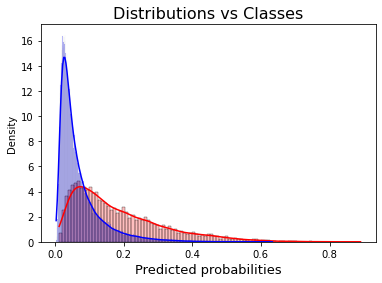

In [19]:
# Distribution of prediction probabilities versus classes
train_predicted_probas = pipe.predict_proba(train)
proba_distributions(train_true,
                    train_predicted_probas,
                    (LOG,run,'Modele/[Out of bag]/Train')
                   )

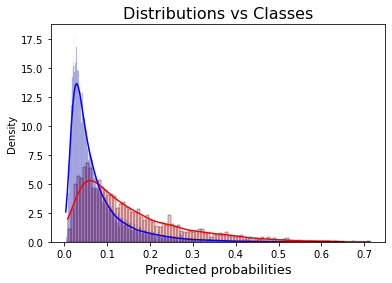

In [20]:
# Distribution of prediction probabilities versus classes
test_predicted_probas = pipe.predict_proba(test)
proba_distributions(test_true,
                    test_predicted_probas,
                    (LOG,run,'Modele/[Out of bag]/Test')
                   )

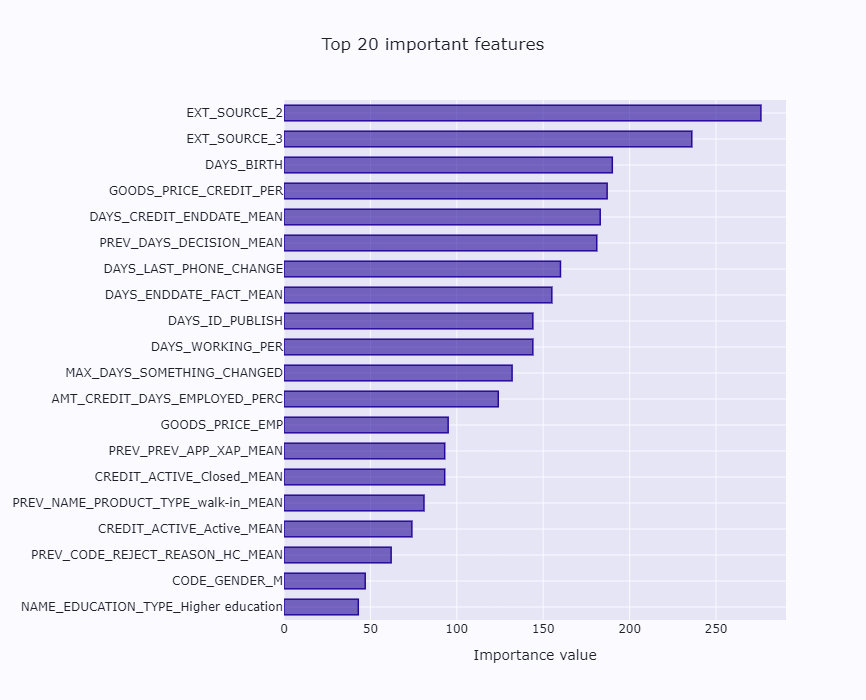

In [21]:
# Feature importance
feature_importance_plot(pipe[-1].feature_importances_,train,(LOG,run,'Modele/[Out of bag]/'))

## Etude des differentes options pour rétablir l'équilbre entre les classes

### Pipeline with sampling  step

In [22]:
pipe_samplers = Pipeline([ 
                          ('over' , None),
                          ('under' , None),
                          ('scaler' , MinMaxScaler(feature_range=(0, 1))),
                          
                          ('model', MODEL)
                     ]
                    )

#### Under Sampling

Pipeline(steps=[('over', None), ('under', RandomUnderSampler(random_state=42)),
                ('scaler', MinMaxScaler()),
                ('model', LGBMClassifier(random_state=42))])

Class balance on fitting model step : Counter({0: 10473, 1: 10473})
TRAIN
               precision    recall  f1-score   support

           0       0.97      0.68      0.80    122457
           1       0.17      0.76      0.28     10473

    accuracy                           0.69    132930
   macro avg       0.57      0.72      0.54    132930
weighted avg       0.91      0.69      0.76    132930

 Scores  on train : {'COST': 0.6775234886656348, 'AUC': 0.7390786058302667}
TEST
               precision    recall  f1-score   support

           0       0.96      0.68      0.79     30615
           1       0.15      0.67      0.25      2618

    accuracy                           0.68     33233
   macro avg       0.56      0.67      0.52     33233
weighted avg       0.90      0.68      0.75     33233

 Scores  on test : {'COST': 0.6743900161284949}


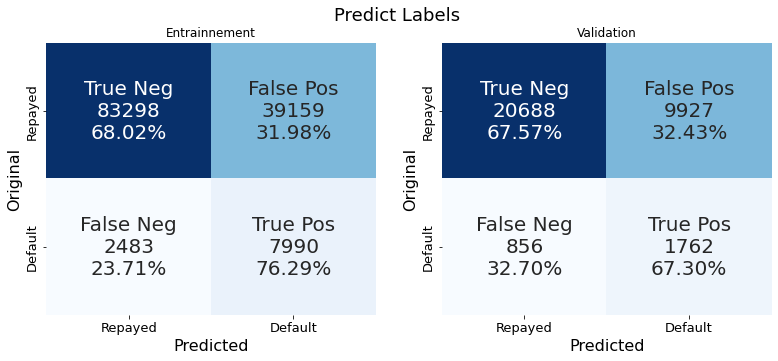

In [23]:
from sklearn.base import clone
from imblearn.under_sampling import RandomUnderSampler 

pipe_under = clone(pipe_samplers)

# set pipeline set 'sampler' to RandomUnderSampler
pipe_under.set_params(**{'under': RandomUnderSampler (random_state=42) })
display(pipe_under)

# fit pipeline on train
pipe_under.fit(train, train_true)


# Count effective classes
sampled_train_true = pipe_under[0:2].fit_resample(train,train_true)[1]
print('Class balance on fitting model step : %s' % Counter(sampled_train_true))
if LOG:
    run['Modele/[Under]/Classe efectives'] = str(Counter(sampled_train_true))


evaluate_estimator(pipe_under,
                   train,
                   train_true,
                   test,
                   test_true,
                   SCORER,
                   cost,
                   cv,
                   log=(LOG,run,'Modele/[Under]/')
                  )

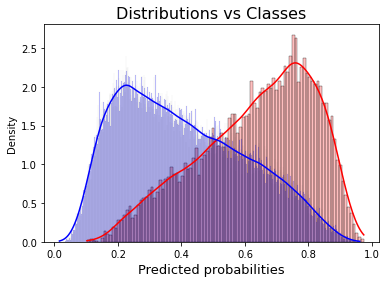

In [24]:
# Distribution of prediction probabilities versus classes on train
train_predicted_probas = pipe_under.predict_proba(train)
proba_distributions(train_true,
                    train_predicted_probas,
                    (LOG,run,'Modele/[Under]/Train')
                   )

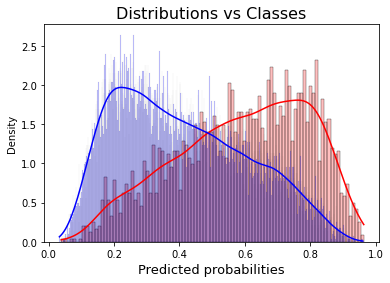

In [25]:
# Distribution of prediction probabilities versus classes on test
test_predicted_probas = pipe_under.predict_proba(test)
proba_distributions(test_true,
                    test_predicted_probas,
                    (LOG,run,'Modele/[Under]/Test')
                   )

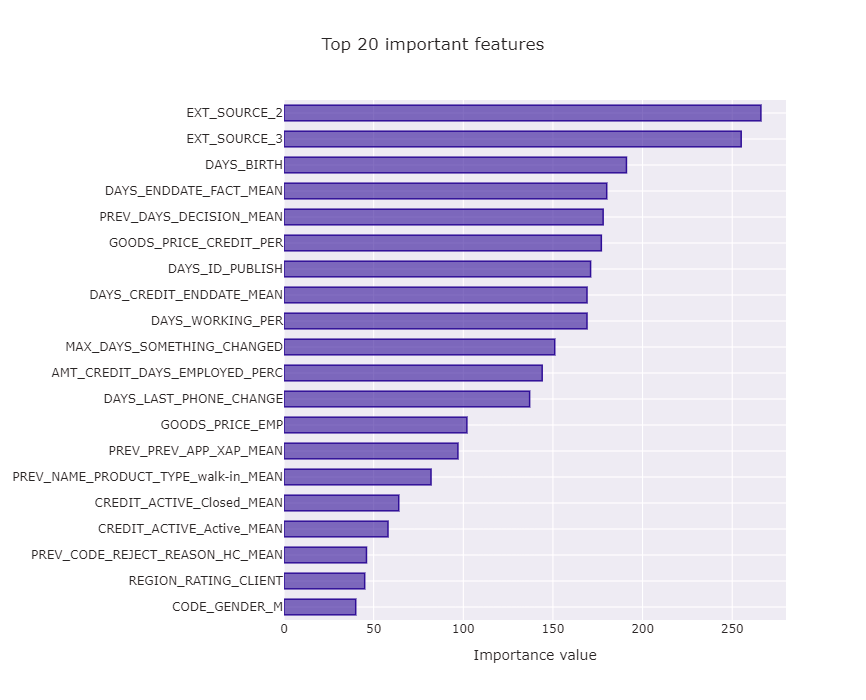

In [26]:
# Feautres importance for model
feature_importance_plot(pipe_under[-1].feature_importances_,
                        train,
                        (LOG,run,'Modele/[Under]/')
                       )

#### Over Sampling

Pipeline(steps=[('over', RandomOverSampler(random_state=42)), ('under', None),
                ('scaler', MinMaxScaler()),
                ('model', LGBMClassifier(random_state=42))])

Class balance on fitting model step : Counter({0: 122457, 1: 122457})
TRAIN
               precision    recall  f1-score   support

           0       0.97      0.72      0.83    122457
           1       0.18      0.74      0.29     10473

    accuracy                           0.72    132930
   macro avg       0.58      0.73      0.56    132930
weighted avg       0.91      0.72      0.78    132930

 Scores  on train : {'COST': 0.6763207728665853, 'AUC': 0.7398807019752234}
TEST
               precision    recall  f1-score   support

           0       0.96      0.71      0.82     30615
           1       0.16      0.63      0.25      2618

    accuracy                           0.71     33233
   macro avg       0.56      0.67      0.54     33233
weighted avg       0.89      0.71      0.77     33233

 Scores  on test : {'COST': 0.6720652645718214}


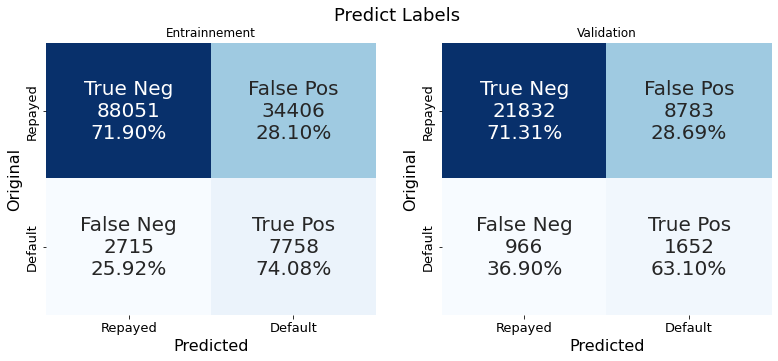

In [27]:
from imblearn.over_sampling import RandomOverSampler 

pipe_over = clone(pipe_samplers)

# set pipeline set 'sampler' to RandomOverSampler
pipe_over.set_params(**{'over': RandomOverSampler (random_state=42) })
display(pipe_over)

# fit pipeline on train
pipe_over.fit(train, train_true)

# Count effective classes
sampled_train_true = [0,1]*train_true.value_counts()[0] #pipe_over[0:2].fit_resample(train,train_true)[1]
print('Class balance on fitting model step : %s' % Counter(sampled_train_true))
if LOG:
    run['Modele/[Over]/Classe efectives'] = str(Counter(sampled_train_true))

# evaluate
evaluate_estimator(pipe_over,
                   train,
                   train_true,
                   test,
                   test_true,
                   SCORER,
                   cost,
                   cv,
                   log=(LOG,run,'Modele/[Over]/')
                  )

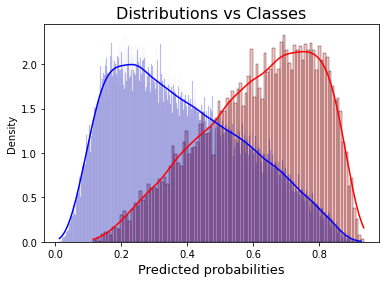

In [28]:
# Distribution of prediction probabilities versus classes on train
train_predicted_probas = pipe_over.predict_proba(train)
proba_distributions(train_true,
                    train_predicted_probas,
                    (LOG,run,'Modele/[Over]/Train')
                   )

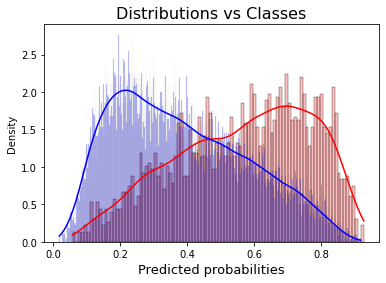

In [29]:
# Distribution of prediction probabilities versus classes on test
test_predicted_probas = pipe_over.predict_proba(test)
proba_distributions(test_true,
                    test_predicted_probas,
                    (LOG,run,'Modele/[Over]/Test')
                   )

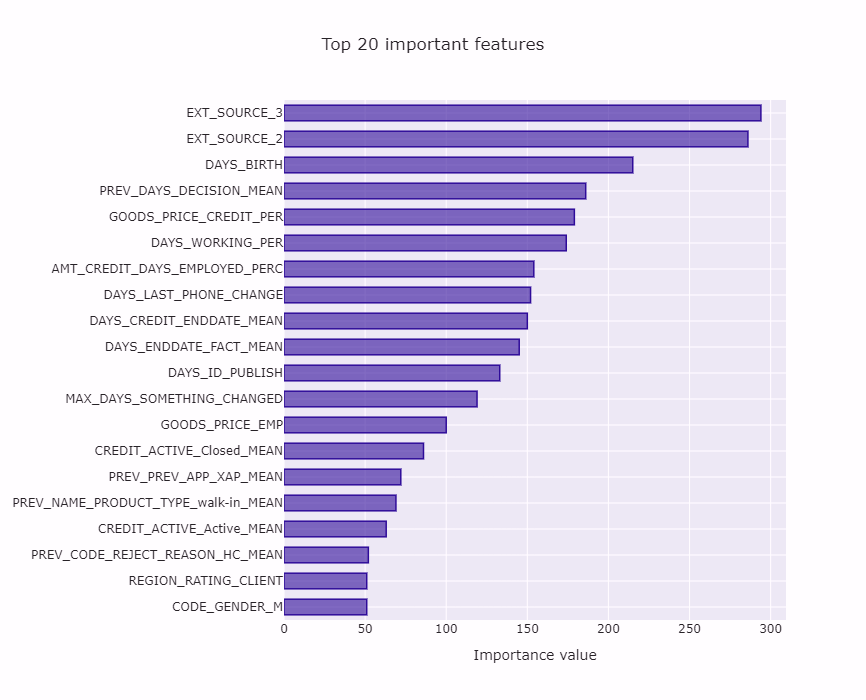

In [30]:
# Feautres importance for model
feature_importance_plot(pipe_over[-1].feature_importances_,
                        train,
                        (LOG,run,'Modele/[Over]/')
                       )

#### Class Weight 'balanced'

Pipeline(steps=[('over', None), ('under', None), ('scaler', MinMaxScaler()),
                ('model',
                 LGBMClassifier(class_weight='balanced', random_state=42))])

Class balance on fitting model step : Counter({0: 122457, 1: 10473})
TRAIN
               precision    recall  f1-score   support

           0       0.97      0.72      0.83    122457
           1       0.18      0.74      0.29     10473

    accuracy                           0.72    132930
   macro avg       0.58      0.73      0.56    132930
weighted avg       0.91      0.72      0.78    132930

 Scores  on train : {'COST': 0.6782165356287388, 'AUC': 0.7415297304424181}
TEST
               precision    recall  f1-score   support

           0       0.96      0.71      0.82     30615
           1       0.16      0.64      0.26      2618

    accuracy                           0.71     33233
   macro avg       0.56      0.68      0.54     33233
weighted avg       0.90      0.71      0.77     33233

 Scores  on test : {'COST': 0.6754803333297151}


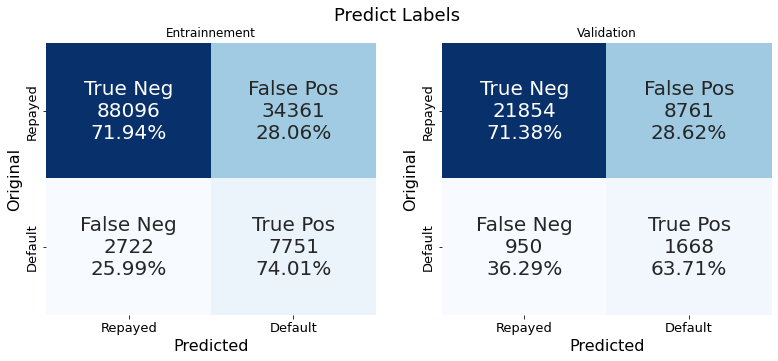

In [31]:

pipe_balance = clone(pipe_samplers)

# fit pipeline on train with sample_weight
pipe_balance.set_params(**{'model__class_weight': 'balanced'})
display(pipe_balance)

# fit pipeline on train
pipe_balance.fit(train, train_true)

# Count effective classes
print('Class balance on fitting model step : %s' % Counter(train_true))
if LOG:
    run['Modele/[Balance]/Classe efectives'] = str(Counter(train_true))

# evaluate
evaluate_estimator(pipe_balance,
                   train,
                   train_true,
                   test,
                   test_true,
                   SCORER,
                   cost,
                   cv,
                   log=(LOG,run,'Modele/[Balance]/')
                  )


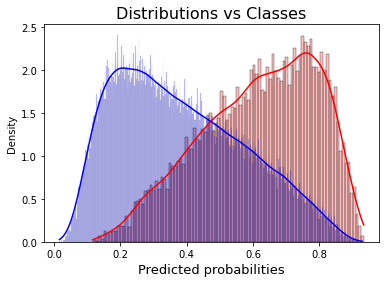

In [32]:
# Distribution of prediction probabilities versus classes on train
train_predicted_probas = pipe_balance.predict_proba(train)
proba_distributions(train_true,
                    train_predicted_probas,
                    (LOG,run,'Modele/[Balance]/Train')
                   )

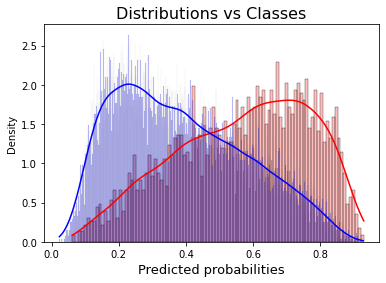

In [33]:
# Distribution of prediction probabilities versus classes on test
test_predicted_probas = pipe_balance.predict_proba(test)
proba_distributions(test_true,
                    test_predicted_probas,
                    (LOG,run,'Modele/[Balance]/Test')
                   )

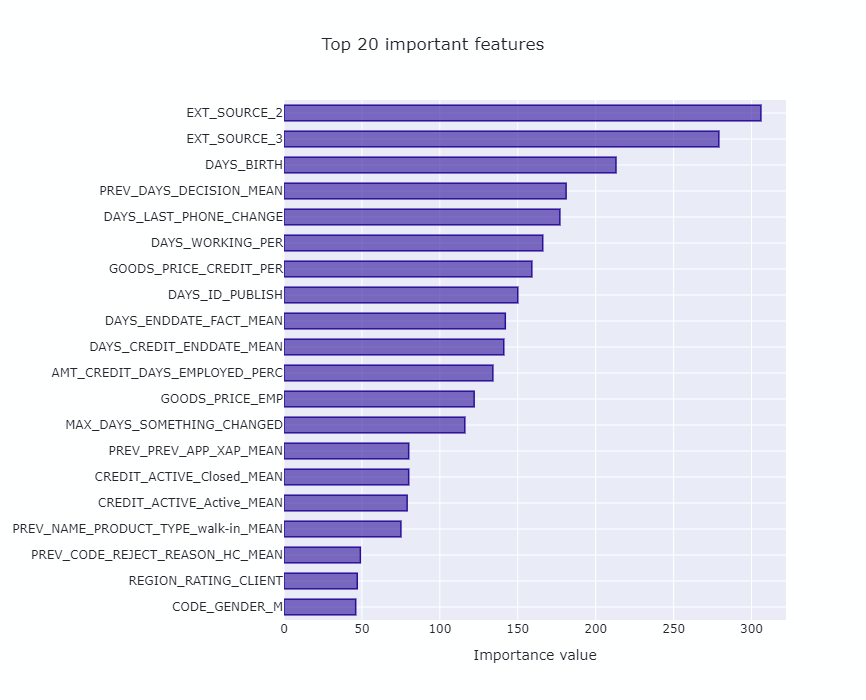

In [34]:
# Feautres importance for model
feature_importance_plot(pipe_balance[-1].feature_importances_,
                        train,
                        (LOG,run,'Modele/[Balance]/')
                       )

### Combinaison des trois solutions précédentes

Pour rééquilibrer les classes:

    * undersampler classe majoritaire en ne prenant que 75% des samples de cette classe
    
    * oversampler classe ninoritaire en duplicant 25% des samples de cette classe
    
    * pondérer les individus en fonction de leur appartenance à majority ou miority (option 'balanced' du modèle)





Pipeline(steps=[('over',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy=0.10690487273083613)),
                ('under',
                 RandomUnderSampler(random_state=42,
                                    sampling_strategy=0.1425398303077815)),
                ('scaler', MinMaxScaler()),
                ('model',
                 LGBMClassifier(class_weight='balanced', random_state=42))])

Class balance on fitting model step : Counter({0: 91840, 1: 13091})
TRAIN
               precision    recall  f1-score   support

           0       0.97      0.72      0.83    122457
           1       0.18      0.73      0.29     10473

    accuracy                           0.72    132930
   macro avg       0.58      0.73      0.56    132930
weighted avg       0.91      0.72      0.78    132930

 Scores  on train : {'COST': 0.6762584981028932, 'AUC': 0.7398371807279777}
TEST
               precision    recall  f1-score   support

           0       0.96      0.71      0.82     30615
           1       0.16      0.63      0.25      2618

    accuracy                           0.71     33233
   macro avg       0.56      0.67      0.54     33233
weighted avg       0.89      0.71      0.77     33233

 Scores  on test : {'COST': 0.6725828873262368}


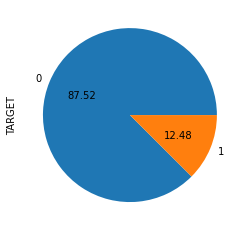

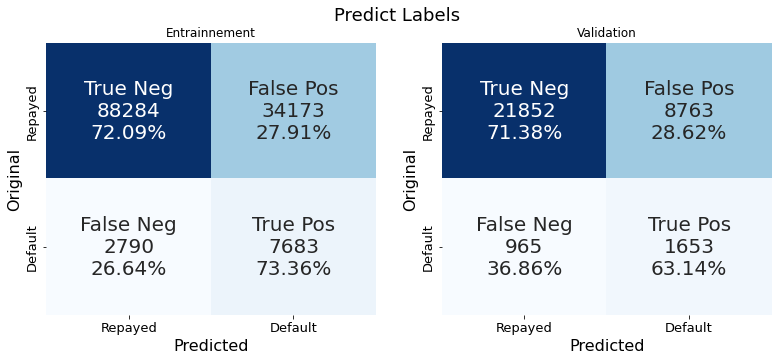

In [35]:
# Initial ratio between classes
ratio_initial = train_true.value_counts()[1]/train_true.value_counts()[0]

# Sampling factors
over = .25
under = .75
# Compute strategy for samplers
over_strategy = ratio_initial *(1 + over)
under_strategy = ratio_initial *(1 + over)/( under)

# set pipeline over and under 
pipe_samplers.set_params(**{'over': RandomOverSampler (random_state=42,sampling_strategy=over_strategy),
                        'under': RandomUnderSampler (random_state=42,sampling_strategy=under_strategy),
                        'model__class_weight': 'balanced'})
display(pipe_samplers)

# fit pipeline on train
pipe_samplers.fit(train, train_true)

# Count effective classes
sampled_train_true = pipe_samplers[0:2].fit_resample(train,train_true)[1]

print('Class balance on fitting model step : %s' % Counter(sampled_train_true))

sampled_train_true.value_counts().plot.pie(autopct='%.2f')
if LOG:
    run['Modele/[Samplers & Weight]/Classe efectives'] = str(Counter(pipe_samplers[0:2].fit_resample(train,train_true)[1]))


# evaluate
evaluate_estimator(pipe_samplers,
                   train,
                   train_true,
                   test,
                   test_true,
                   SCORER,
                   cost,
                   cv,
                   log=(LOG,run,'Modele/[Samplers & Weight]/'))

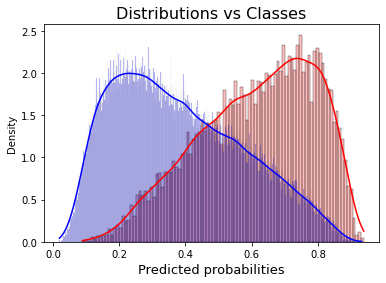

In [36]:
# Distribution of prediction probabilities versus classes
train_predicted_probas = pipe_samplers.predict_proba(train)
proba_distributions(train_true,train_predicted_probas,(LOG,run,'Modele/[Samplers & Weight]/Train'))

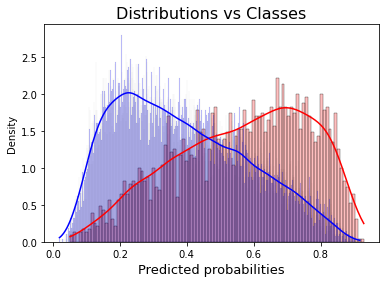

In [37]:
# Distribution of prediction probabilities versus classes
test_predicted_probas = pipe_samplers.predict_proba(test)
proba_distributions(test_true,test_predicted_probas,(LOG,run,'Modele/[Samplers & Weight]/Test'))

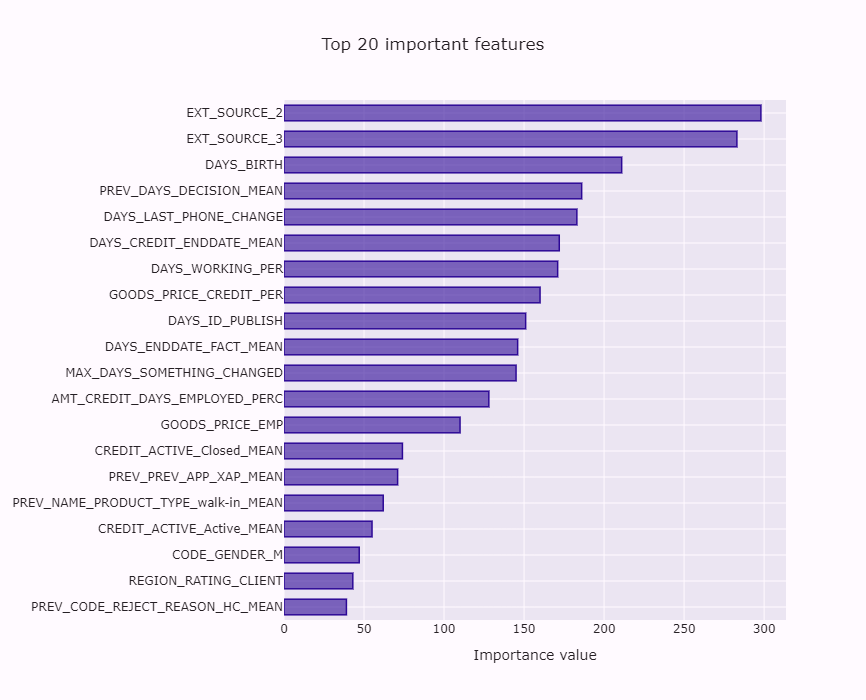

In [38]:
feature_importance_plot(pipe_samplers[-1].feature_importances_,train,(LOG,run,'Modele/[Samplers & Weight]/'))

Mieux

Grid search pour déterminer la meilleure approche

## Recherche de la combinaison optimale

In [39]:
from sklearn.preprocessing import StandardScaler  # MODIFIE
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer

from joblib import Memory
from shutil import rmtree
# Create a temporary folder to store the transformers of the pipeline
# location = 'cachedir2'
# memory = Memory(location=location, verbose=0)


# Reset pipeline parameters
pipe_optim = Pipeline([ #('variance' , VarianceThreshold(threshold=0.0)),
                            ('over' , RandomOverSampler (random_state=42)),
                            ('under' , RandomUnderSampler(random_state=42)),
                            ('scaler' , None),

                            ('model', lgb.LGBMClassifier(random_state=42, n_jobs=-1))
                        ],
#                         memory=memory
                       )

In [40]:
pipe_optim.get_params()

{'memory': None,
 'steps': [('over', RandomOverSampler(random_state=42)),
  ('under', RandomUnderSampler(random_state=42)),
  ('scaler', None),
  ('model', LGBMClassifier(random_state=42))],
 'verbose': False,
 'over': RandomOverSampler(random_state=42),
 'under': RandomUnderSampler(random_state=42),
 'scaler': None,
 'model': LGBMClassifier(random_state=42),
 'over__random_state': 42,
 'over__sampling_strategy': 'auto',
 'over__shrinkage': None,
 'under__random_state': 42,
 'under__replacement': False,
 'under__sampling_strategy': 'auto',
 'model__boosting_type': 'gbdt',
 'model__class_weight': None,
 'model__colsample_bytree': 1.0,
 'model__importance_type': 'split',
 'model__learning_rate': 0.1,
 'model__max_depth': -1,
 'model__min_child_samples': 20,
 'model__min_child_weight': 0.001,
 'model__min_split_gain': 0.0,
 'model__n_estimators': 100,
 'model__n_jobs': -1,
 'model__num_leaves': 31,
 'model__objective': None,
 'model__random_state': 42,
 'model__reg_alpha': 0.0,
 'model__r

In [41]:
### fonction to maximize
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.base import clone

ratio_initial = train_true.value_counts()[1]/train_true.value_counts()[0]
std = StandardScaler()
mmx = MinMaxScaler(feature_range=(0, 1))
qt = QuantileTransformer(n_quantiles=10000,
                        output_distribution='normal',
                        ignore_implicit_zeros=False,
                        subsample=100000,
                        random_state=42)
rob = RobustScaler(with_centering=True,
                        with_scaling=True,
                        quantile_range=(25.0, 75.0),
                        copy=True,
                        unit_variance=True)
pwt = PowerTransformer(method='yeo-johnson',
                     standardize=True,
                     copy=True)

def Opt_search(trial):
    # the function gets a set of variable parameters in "param"
    # we use theses params to set pipeline params
    
    # Initialize params
    params = {}
    pipe = clone(pipe_optim)
    
        
    # Variance space
#     params['variance__threshold'] = trial.suggest_float('variance', 0, .1)  # MODIFIE
    
    # ratios for samplers
    o_r = trial.suggest_float('ratio_over', 0, 1)
    u_r = trial.suggest_float('ratio_under', .5, 1)
    
    #over sampling
    params['over__sampling_strategy'] =  ratio_initial *(1 + o_r)
    
    # under sampling
    params['under__sampling_strategy'] = ratio_initial *(1 + o_r)/( u_r) 
    
    # sample weight
#     x = trial.suggest_float('weight',0.5,0.99)  # MODIFIE
#     params['model__class_weight'] = {0 : 1-x, 1 : x}
    params['model__class_weight'] = 'balanced'
        
    # Scaller space
    scaler_name = trial.suggest_categorical('scaller name', ['StandardScaler',
                                                             'MinMaxScaler',
                                                             'QuantileTransformer',
                                                             'RobustScaler',
                                                             'PowerTransformer'
                                                            ])
    if scaler_name == 'MinMaxScaler':
        params['scaler'] = mmx
                                             
    elif scaler_name == 'StandardScaler':
        params['scaler'] =  std   
        
    elif scaler_name == 'QuantileTransformer':
        params['scaler'] =  qt
        
    elif scaler_name == 'RobustScaler':
        params['scaler'] =  rob
        
    elif scaler_name == 'PowerTransformer':
        params['scaler'] =  pwt
    
    # light Gradient Boosting space 
    params['model__boosting_type'] = trial.suggest_categorical('model__boosting_type',['gbdt',
                                                                                       'dart',
                                                                                       
                                                                                       ])
    params['model__max_depth'] = trial.suggest_int('model__max_depth',2,25)
    params['model__learning_rate'] = trial.suggest_float('model__learning_rate',1E-5,1)
    params['model__n_estimators'] = trial.suggest_int('model__n_estimators',1,200)
    params['model__num_leaves'] = trial.suggest_int('model__num_leaves',2,50)
    params['model__min_split_gain'] = trial.suggest_float('model__min_split_gain',0,1)
    params['model__subsample_for_bin'] = 10000
    params['model__objective'] = 'binary'
#     params['model__early_stopping_rounds'] = 100
    params['model__metric'] = trial.suggest_categorical('model__metric',[
#                                                                          'auc',
                                                                         'binary_error',
                                                                         'binary_logloss'
                                                                        ]
                                                       )
    params['model__subsample'] = trial.suggest_float('model__subsample',0.03,1)
    params['model__reg_alpha'] = trial.suggest_float('model__reg_alpha', 1E-3, 100)#, log=True)
    params['model__reg_lambda'] = trial.suggest_float('model__reg_lambda', 1E-3, 100)#, log=True)
    params['model__importance_type'] = trial.suggest_categorical('model__importance_type',['split',
                                                                                           'gain'])
    
               
#     print(params)
    
    # we use theses params to set pipeline params
    pipe.set_params(**params)
               
#     print(pipe_optim.get_params(deep=False))    
        
    # score
    score = cross_validate(pipe,
                           train,
                           train_true,
                           scoring=SCORER,
                           n_jobs=1,
                           cv=cv)
    
    print('> cv cost score mean: %.4f (\u00B1 %.4f) <> roc auc score mean: %.4f (\u00B1 %.4f) < ' % (
                                                                                        score['test_COST'].mean(),
                                                                                        score['test_COST'].std(),
                                                                                        score['test_AUC'].mean(),
                                                                                        score['test_AUC'].std()
                                                                                       )
         )
    
    if LOG:
        run['AUC'].log(score['test_AUC'].mean())
        run['COST'].log(score['test_COST'].mean())
        
    return score['test_COST'].mean()
    

In [42]:
pipe_optim.get_params(deep=False)

{'memory': None,
 'steps': [('over', RandomOverSampler(random_state=42)),
  ('under', RandomUnderSampler(random_state=42)),
  ('scaler', None),
  ('model', LGBMClassifier(random_state=42))],
 'verbose': False}

In [43]:
# Create study the first time or append existing
import os.path
from os import path
import optuna
from optuna.samplers import TPESampler

 
# Studiing n_iter times
n_iter = ITERATIONS

# Optimize
if LOG and RESUME:
    # Load Optuna Study from the Neptune Run
    study = optuna_utils.load_study_from_run(run)  
    study.optimize(Opt_search, n_trials=n_iter, n_jobs=JOBS, callbacks=[neptune_callback])
elif LOG and not RESUME:
    name = 'LGBM '+EDA
    study = optuna.create_study(study_name=name,
                                    direction='maximize',

                                    sampler=TPESampler(n_startup_trials= 50)
                                   )
    study.optimize(Opt_search, n_trials=n_iter, n_jobs=JOBS, callbacks=[neptune_callback])
    
else:
    # Local run
    save_path = 'Studies/'
    name =save_path+'NEWRUN_lgbm_'+EDA+'reg_COST1'
    file_name = name+'.study'

    if path.exists(file_name):
        # load study
        study = joblib.load(file_name)
        print('Loading {}'.format(file_name))

        # Load Optuna Study from the Neptune Run
    #     study = optuna_utils.load_study_from_run(run)

    else:
        # Otherwise create study
        print('Creating a new study named {}'.format(name))
        study = optuna.create_study(study_name=name,
                                    direction='maximize',

                                    sampler=TPESampler(n_startup_trials= 10)
                                   )
        
    study.optimize(Opt_search, n_trials=n_iter, n_jobs=JOBS)

# # save the sutdy 
# joblib.dump(study, file_name)

# print best results
print('Best custom_score = {} for :\n'.format(study.best_value))

for key, value in study.best_params.items():
    print("    {}: {}".format(key, value))

[I 2021-07-13 10:10:04,706] Trial 385 finished with value: 0.680190714593934 and parameters: {'ratio_over': 0.05780456759270055, 'ratio_under': 0.9809952372712162, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 8, 'model__learning_rate': 0.6996096332844312, 'model__n_estimators': 197, 'model__num_leaves': 12, 'model__min_split_gain': 0.5274367291655525, 'model__metric': 'binary_logloss', 'model__subsample': 0.07411466946507507, 'model__reg_alpha': 59.50566073304302, 'model__reg_lambda': 4.462539668276181, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6802 (± 0.0034) <> roc auc score mean: 0.7442 (± 0.0031) < 


[I 2021-07-13 10:10:25,822] Trial 386 finished with value: 0.6824243354572557 and parameters: {'ratio_over': 0.1377659177817889, 'ratio_under': 0.9078528947065206, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.7538753521895032, 'model__n_estimators': 184, 'model__num_leaves': 5, 'model__min_split_gain': 0.5886659852022863, 'model__metric': 'binary_logloss', 'model__subsample': 0.45376493781650346, 'model__reg_alpha': 62.91177856345414, 'model__reg_lambda': 10.368921087822995, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6824 (± 0.0039) <> roc auc score mean: 0.7455 (± 0.0037) < 


[I 2021-07-13 10:10:48,092] Trial 387 finished with value: 0.6815502530854837 and parameters: {'ratio_over': 0.09940009754012924, 'ratio_under': 0.9902258234675989, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.6910126484176448, 'model__n_estimators': 178, 'model__num_leaves': 5, 'model__min_split_gain': 0.636593385688781, 'model__metric': 'binary_logloss', 'model__subsample': 0.44268385364781027, 'model__reg_alpha': 58.385319011800476, 'model__reg_lambda': 13.884575505565572, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6816 (± 0.0034) <> roc auc score mean: 0.7460 (± 0.0041) < 


[I 2021-07-13 10:11:04,483] Trial 388 finished with value: 0.6792176499217273 and parameters: {'ratio_over': 0.15970646229212812, 'ratio_under': 0.9014114221977149, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 8, 'model__learning_rate': 0.721664350293758, 'model__n_estimators': 193, 'model__num_leaves': 2, 'model__min_split_gain': 0.5430966607791754, 'model__metric': 'binary_logloss', 'model__subsample': 0.06276884569149, 'model__reg_alpha': 61.56344290542154, 'model__reg_lambda': 31.159838275747227, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6792 (± 0.0044) <> roc auc score mean: 0.7430 (± 0.0043) < 


[I 2021-07-13 10:11:28,064] Trial 389 finished with value: 0.6813527688779628 and parameters: {'ratio_over': 0.12294252105786238, 'ratio_under': 0.9638263869555355, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 9, 'model__learning_rate': 0.775239156128386, 'model__n_estimators': 189, 'model__num_leaves': 5, 'model__min_split_gain': 0.5083864169757987, 'model__metric': 'binary_logloss', 'model__subsample': 0.033455044418168906, 'model__reg_alpha': 55.89826837394857, 'model__reg_lambda': 34.68229126829328, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6814 (± 0.0033) <> roc auc score mean: 0.7457 (± 0.0036) < 


[I 2021-07-13 10:11:42,807] Trial 390 finished with value: 0.6825549939395688 and parameters: {'ratio_over': 0.18088879297114052, 'ratio_under': 0.9735244359640065, 'scaller name': 'MinMaxScaler', 'model__boosting_type': 'dart', 'model__max_depth': 2, 'model__learning_rate': 0.7454747566184046, 'model__n_estimators': 183, 'model__num_leaves': 15, 'model__min_split_gain': 0.539272955388325, 'model__metric': 'binary_logloss', 'model__subsample': 0.4916110284239158, 'model__reg_alpha': 42.596620411764725, 'model__reg_lambda': 29.020297395705967, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6826 (± 0.0040) <> roc auc score mean: 0.7457 (± 0.0041) < 


You are attempting to create an in-memory file that is 50.5MB large. Neptune supports logging in-memory file objects smaller than 32MB. Resize or increase compression of this object
[I 2021-07-13 10:14:00,460] Trial 391 finished with value: 0.6819750719239676 and parameters: {'ratio_over': 0.08205238148895516, 'ratio_under': 0.9113951337272255, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 7, 'model__learning_rate': 0.6628082010766194, 'model__n_estimators': 187, 'model__num_leaves': 11, 'model__min_split_gain': 0.5213548216407321, 'model__metric': 'binary_logloss', 'model__subsample': 0.09839532872274345, 'model__reg_alpha': 58.43254918966309, 'model__reg_lambda': 14.45857831043732, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6820 (± 0.0039) <> roc auc score mean: 0.7446 (± 0.0036) < 


[I 2021-07-13 10:14:20,037] Trial 392 finished with value: 0.6818743537005261 and parameters: {'ratio_over': 0.14501209074864604, 'ratio_under': 0.8876420279785906, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 3, 'model__learning_rate': 0.6319254520138651, 'model__n_estimators': 197, 'model__num_leaves': 3, 'model__min_split_gain': 0.5685979633810263, 'model__metric': 'binary_logloss', 'model__subsample': 0.5110346871912735, 'model__reg_alpha': 56.695036226377326, 'model__reg_lambda': 27.301428914133222, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6819 (± 0.0036) <> roc auc score mean: 0.7449 (± 0.0037) < 


[I 2021-07-13 10:14:47,938] Trial 393 finished with value: 0.6821860787394473 and parameters: {'ratio_over': 0.11210720792616473, 'ratio_under': 0.9154741263768029, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 13, 'model__learning_rate': 0.7185447666646914, 'model__n_estimators': 173, 'model__num_leaves': 12, 'model__min_split_gain': 0.05717124569727009, 'model__metric': 'binary_logloss', 'model__subsample': 0.4704671022836576, 'model__reg_alpha': 60.85428769123292, 'model__reg_lambda': 32.735893293231165, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6822 (± 0.0034) <> roc auc score mean: 0.7445 (± 0.0026) < 


[I 2021-07-13 10:15:04,316] Trial 394 finished with value: 0.6793939439616141 and parameters: {'ratio_over': 0.16531754590226463, 'ratio_under': 0.901004745133892, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.7584400684367066, 'model__n_estimators': 193, 'model__num_leaves': 2, 'model__min_split_gain': 0.10781369357044782, 'model__metric': 'binary_logloss', 'model__subsample': 0.08716595562785741, 'model__reg_alpha': 45.29783701483679, 'model__reg_lambda': 25.471920926773738, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6794 (± 0.0048) <> roc auc score mean: 0.7431 (± 0.0044) < 


[I 2021-07-13 10:15:25,816] Trial 395 finished with value: 0.6825086624255109 and parameters: {'ratio_over': 0.1908836805685596, 'ratio_under': 0.9847426459529992, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 3, 'model__learning_rate': 0.7819495792909089, 'model__n_estimators': 179, 'model__num_leaves': 4, 'model__min_split_gain': 0.5656399827335455, 'model__metric': 'binary_error', 'model__subsample': 0.3068710221980331, 'model__reg_alpha': 55.34444493718084, 'model__reg_lambda': 30.7637941133051, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6825 (± 0.0024) <> roc auc score mean: 0.7448 (± 0.0039) < 


[I 2021-07-13 10:15:41,278] Trial 396 finished with value: 0.6816537529511737 and parameters: {'ratio_over': 0.13140046118218654, 'ratio_under': 0.9995542518786804, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 2, 'model__learning_rate': 0.7300529154236053, 'model__n_estimators': 106, 'model__num_leaves': 6, 'model__min_split_gain': 0.5925667014610306, 'model__metric': 'binary_error', 'model__subsample': 0.4318051893069975, 'model__reg_alpha': 59.55887774767197, 'model__reg_lambda': 27.792086194623273, 'model__importance_type': 'split'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6817 (± 0.0039) <> roc auc score mean: 0.7455 (± 0.0040) < 


[I 2021-07-13 10:16:02,512] Trial 397 finished with value: 0.6810770693730925 and parameters: {'ratio_over': 0.1513482813968524, 'ratio_under': 0.8739014449504761, 'scaller name': 'RobustScaler', 'model__boosting_type': 'dart', 'model__max_depth': 7, 'model__learning_rate': 0.6909845900402188, 'model__n_estimators': 190, 'model__num_leaves': 10, 'model__min_split_gain': 0.09042100237578737, 'model__metric': 'binary_error', 'model__subsample': 0.4951106460037062, 'model__reg_alpha': 57.623375669415, 'model__reg_lambda': 11.40723228201791, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6811 (± 0.0036) <> roc auc score mean: 0.7449 (± 0.0036) < 


[I 2021-07-13 10:16:28,641] Trial 398 finished with value: 0.683743365378869 and parameters: {'ratio_over': 0.16957017112872597, 'ratio_under': 0.9591337559614688, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 5, 'model__learning_rate': 0.7584227515913333, 'model__n_estimators': 200, 'model__num_leaves': 7, 'model__min_split_gain': 0.5065673185769584, 'model__metric': 'binary_error', 'model__subsample': 0.2732746230041611, 'model__reg_alpha': 63.95474320537444, 'model__reg_lambda': 8.772659353052793, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6837 (± 0.0024) <> roc auc score mean: 0.7458 (± 0.0034) < 


[I 2021-07-13 10:16:57,030] Trial 399 finished with value: 0.6818323303257338 and parameters: {'ratio_over': 0.18261542341405523, 'ratio_under': 0.9651404414048644, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 5, 'model__learning_rate': 0.7280679019736558, 'model__n_estimators': 200, 'model__num_leaves': 8, 'model__min_split_gain': 0.5027481440100036, 'model__metric': 'binary_error', 'model__subsample': 0.5398290387863821, 'model__reg_alpha': 63.00553360376474, 'model__reg_lambda': 9.355747616977233, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6818 (± 0.0031) <> roc auc score mean: 0.7451 (± 0.0033) < 


[I 2021-07-13 10:17:24,714] Trial 400 finished with value: 0.6810080658562829 and parameters: {'ratio_over': 0.1647696601426954, 'ratio_under': 0.9592137064878287, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 5, 'model__learning_rate': 0.7505044719976206, 'model__n_estimators': 197, 'model__num_leaves': 9, 'model__min_split_gain': 0.5359368152556112, 'model__metric': 'binary_logloss', 'model__subsample': 0.053292258992136535, 'model__reg_alpha': 59.851147129526474, 'model__reg_lambda': 10.70758916559968, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6810 (± 0.0038) <> roc auc score mean: 0.7447 (± 0.0029) < 


You are attempting to create an in-memory file that is 52.7MB large. Neptune supports logging in-memory file objects smaller than 32MB. Resize or increase compression of this object
[I 2021-07-13 10:19:53,471] Trial 401 finished with value: 0.6811214959947918 and parameters: {'ratio_over': 0.13706162291571727, 'ratio_under': 0.9753185129925913, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.7634974663779028, 'model__n_estimators': 183, 'model__num_leaves': 18, 'model__min_split_gain': 0.5020582731035129, 'model__metric': 'binary_error', 'model__subsample': 0.2690123337867674, 'model__reg_alpha': 68.27331917340892, 'model__reg_lambda': 4.407869921560147, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6811 (± 0.0027) <> roc auc score mean: 0.7437 (± 0.0029) < 


[I 2021-07-13 10:20:07,199] Trial 402 finished with value: 0.6786888382307195 and parameters: {'ratio_over': 0.11001232471071283, 'ratio_under': 0.9522936866319287, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'gbdt', 'model__max_depth': 5, 'model__learning_rate': 0.7069350749994905, 'model__n_estimators': 176, 'model__num_leaves': 7, 'model__min_split_gain': 0.6666515418800929, 'model__metric': 'binary_error', 'model__subsample': 0.10972657213331488, 'model__reg_alpha': 64.88115629968885, 'model__reg_lambda': 15.399152066609913, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6787 (± 0.0031) <> roc auc score mean: 0.7412 (± 0.0038) < 


[I 2021-07-13 10:20:33,876] Trial 403 finished with value: 0.6803686272883344 and parameters: {'ratio_over': 0.1545314797866997, 'ratio_under': 0.9411447800035886, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 4, 'model__learning_rate': 0.7407627385734722, 'model__n_estimators': 200, 'model__num_leaves': 7, 'model__min_split_gain': 0.5244497029167866, 'model__metric': 'binary_error', 'model__subsample': 0.07704841116634772, 'model__reg_alpha': 67.28479187577805, 'model__reg_lambda': 7.18122598208147, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6804 (± 0.0032) <> roc auc score mean: 0.7456 (± 0.0036) < 


[I 2021-07-13 10:21:04,867] Trial 404 finished with value: 0.6808591953756474 and parameters: {'ratio_over': 0.19202171186016223, 'ratio_under': 0.9687893600564359, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.7744897705382777, 'model__n_estimators': 185, 'model__num_leaves': 21, 'model__min_split_gain': 0.4891907509136913, 'model__metric': 'binary_error', 'model__subsample': 0.7913088064561691, 'model__reg_alpha': 63.84492308116837, 'model__reg_lambda': 83.5982009518861, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6809 (± 0.0049) <> roc auc score mean: 0.7433 (± 0.0029) < 


[I 2021-07-13 10:21:21,527] Trial 405 finished with value: 0.6826616516108999 and parameters: {'ratio_over': 0.12682296024603112, 'ratio_under': 0.991956303570926, 'scaller name': 'MinMaxScaler', 'model__boosting_type': 'dart', 'model__max_depth': 3, 'model__learning_rate': 0.6744055489973905, 'model__n_estimators': 166, 'model__num_leaves': 9, 'model__min_split_gain': 0.1542344846625791, 'model__metric': 'binary_logloss', 'model__subsample': 0.5773414170424749, 'model__reg_alpha': 66.37623214270968, 'model__reg_lambda': 6.517757165688679, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6827 (± 0.0044) <> roc auc score mean: 0.7465 (± 0.0033) < 


[I 2021-07-13 10:21:52,677] Trial 406 finished with value: 0.6813872793096113 and parameters: {'ratio_over': 0.07647566646936099, 'ratio_under': 0.9555721732114872, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 5, 'model__learning_rate': 0.719967728741725, 'model__n_estimators': 195, 'model__num_leaves': 10, 'model__min_split_gain': 0.5470732084815556, 'model__metric': 'binary_error', 'model__subsample': 0.48026606955698387, 'model__reg_alpha': 61.566388362010876, 'model__reg_lambda': 8.490603167109184, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6814 (± 0.0030) <> roc auc score mean: 0.7459 (± 0.0039) < 


[I 2021-07-13 10:22:13,087] Trial 407 finished with value: 0.6808464260674151 and parameters: {'ratio_over': 0.6114831552148613, 'ratio_under': 0.8028364519853397, 'scaller name': 'StandardScaler', 'model__boosting_type': 'dart', 'model__max_depth': 3, 'model__learning_rate': 0.418655638987786, 'model__n_estimators': 200, 'model__num_leaves': 8, 'model__min_split_gain': 0.5756962173736814, 'model__metric': 'binary_error', 'model__subsample': 0.5095235131604304, 'model__reg_alpha': 55.66406041256661, 'model__reg_lambda': 25.765712682575913, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6808 (± 0.0025) <> roc auc score mean: 0.7458 (± 0.0037) < 


[I 2021-07-13 10:22:24,232] Trial 408 finished with value: 0.6381171981956106 and parameters: {'ratio_over': 0.995744382893753, 'ratio_under': 0.943294052195166, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 3, 'model__learning_rate': 0.7546073877640227, 'model__n_estimators': 1, 'model__num_leaves': 5, 'model__min_split_gain': 0.51044538066055, 'model__metric': 'binary_error', 'model__subsample': 0.33851718741942055, 'model__reg_alpha': 58.20209688262602, 'model__reg_lambda': 13.899969503382206, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6381 (± 0.0062) <> roc auc score mean: 0.6829 (± 0.0062) < 


[I 2021-07-13 10:22:52,579] Trial 409 finished with value: 0.6804016913732365 and parameters: {'ratio_over': 0.17147183110928788, 'ratio_under': 0.9785555137839986, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 4, 'model__learning_rate': 0.7978473275481854, 'model__n_estimators': 171, 'model__num_leaves': 13, 'model__min_split_gain': 0.6270432166763438, 'model__metric': 'binary_error', 'model__subsample': 0.22192912043764979, 'model__reg_alpha': 54.02703802419206, 'model__reg_lambda': 12.03414145557732, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6804 (± 0.0029) <> roc auc score mean: 0.7432 (± 0.0038) < 


[I 2021-07-13 10:23:21,239] Trial 410 finished with value: 0.6809382692801125 and parameters: {'ratio_over': 0.14257126260814335, 'ratio_under': 0.9604562022218518, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 14, 'model__learning_rate': 0.6905985561340913, 'model__n_estimators': 188, 'model__num_leaves': 11, 'model__min_split_gain': 0.4873538253203942, 'model__metric': 'binary_logloss', 'model__subsample': 0.4079868984586026, 'model__reg_alpha': 62.444772998793916, 'model__reg_lambda': 3.291415073772364, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6809 (± 0.0037) <> roc auc score mean: 0.7442 (± 0.0040) < 


You are attempting to create an in-memory file that is 54.9MB large. Neptune supports logging in-memory file objects smaller than 32MB. Resize or increase compression of this object
[I 2021-07-13 10:25:41,221] Trial 411 finished with value: 0.6834923546913363 and parameters: {'ratio_over': 0.09998937383287694, 'ratio_under': 0.8529892719404312, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 5, 'model__learning_rate': 0.7373194151714769, 'model__n_estimators': 180, 'model__num_leaves': 4, 'model__min_split_gain': 0.0005712059177718221, 'model__metric': 'binary_error', 'model__subsample': 0.5236505930736629, 'model__reg_alpha': 56.765962383608894, 'model__reg_lambda': 27.794535011014545, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6835 (± 0.0035) <> roc auc score mean: 0.7460 (± 0.0036) < 


[I 2021-07-13 10:26:00,223] Trial 412 finished with value: 0.6832155158625399 and parameters: {'ratio_over': 0.0965200423833249, 'ratio_under': 0.8772509807819554, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.740908490515436, 'model__n_estimators': 180, 'model__num_leaves': 4, 'model__min_split_gain': 0.028192419395077516, 'model__metric': 'binary_error', 'model__subsample': 0.5008145773893556, 'model__reg_alpha': 60.31561336519226, 'model__reg_lambda': 29.250161672662546, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6832 (± 0.0046) <> roc auc score mean: 0.7466 (± 0.0039) < 


[I 2021-07-13 10:26:14,770] Trial 413 finished with value: 0.6789975271740658 and parameters: {'ratio_over': 0.09732150111808248, 'ratio_under': 0.8440128952723662, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.7325972253847159, 'model__n_estimators': 180, 'model__num_leaves': 2, 'model__min_split_gain': 0.0024008739323336335, 'model__metric': 'binary_error', 'model__subsample': 0.4869545818237569, 'model__reg_alpha': 58.85537317706998, 'model__reg_lambda': 29.155845711220714, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6790 (± 0.0051) <> roc auc score mean: 0.7428 (± 0.0050) < 


[I 2021-07-13 10:26:32,075] Trial 414 finished with value: 0.6800324421407857 and parameters: {'ratio_over': 0.05752060341523704, 'ratio_under': 0.8522809528228013, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.7182547835392963, 'model__n_estimators': 180, 'model__num_leaves': 3, 'model__min_split_gain': 0.03271805955448957, 'model__metric': 'binary_error', 'model__subsample': 0.5168227069444048, 'model__reg_alpha': 61.24233542948834, 'model__reg_lambda': 9.280361351379936, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6800 (± 0.0042) <> roc auc score mean: 0.7441 (± 0.0044) < 


[I 2021-07-13 10:26:50,518] Trial 415 finished with value: 0.6821036172305066 and parameters: {'ratio_over': 0.11013122970329517, 'ratio_under': 0.8113100256052482, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 7, 'model__learning_rate': 0.7453499421552561, 'model__n_estimators': 177, 'model__num_leaves': 4, 'model__min_split_gain': 0.01377652643580492, 'model__metric': 'binary_error', 'model__subsample': 0.4988130017185438, 'model__reg_alpha': 63.05684418510854, 'model__reg_lambda': 31.28641464717557, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6821 (± 0.0039) <> roc auc score mean: 0.7461 (± 0.0039) < 


[I 2021-07-13 10:27:09,167] Trial 416 finished with value: 0.6822062142555619 and parameters: {'ratio_over': 0.09302638734669884, 'ratio_under': 0.8596196176527493, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.7125980833999107, 'model__n_estimators': 181, 'model__num_leaves': 4, 'model__min_split_gain': 0.04588873164423169, 'model__metric': 'binary_logloss', 'model__subsample': 0.5277997185838763, 'model__reg_alpha': 65.70324125384437, 'model__reg_lambda': 15.889366174005024, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6822 (± 0.0034) <> roc auc score mean: 0.7462 (± 0.0039) < 


[I 2021-07-13 10:27:28,018] Trial 417 finished with value: 0.6816469634052021 and parameters: {'ratio_over': 0.12803596861649597, 'ratio_under': 0.8348544168889783, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.7001036546562838, 'model__n_estimators': 193, 'model__num_leaves': 3, 'model__min_split_gain': 0.02145179807045851, 'model__metric': 'binary_error', 'model__subsample': 0.4583415073123011, 'model__reg_alpha': 71.77686823612339, 'model__reg_lambda': 24.576372275044573, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6816 (± 0.0040) <> roc auc score mean: 0.7449 (± 0.0038) < 


[I 2021-07-13 10:27:51,723] Trial 418 finished with value: 0.6817880209895474 and parameters: {'ratio_over': 0.08135932393636745, 'ratio_under': 0.8756940113470203, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 5, 'model__learning_rate': 0.7370212987201166, 'model__n_estimators': 186, 'model__num_leaves': 4, 'model__min_split_gain': 0.022778471938062667, 'model__metric': 'binary_error', 'model__subsample': 0.514885018695601, 'model__reg_alpha': 59.844395687327975, 'model__reg_lambda': 28.982815108991698, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6818 (± 0.0043) <> roc auc score mean: 0.7462 (± 0.0046) < 


[I 2021-07-13 10:28:11,107] Trial 419 finished with value: 0.6805109663860748 and parameters: {'ratio_over': 0.03656856797356686, 'ratio_under': 0.8673787903295762, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 8, 'model__learning_rate': 0.7561189379466915, 'model__n_estimators': 189, 'model__num_leaves': 5, 'model__min_split_gain': 0.0006501897065311379, 'model__metric': 'binary_error', 'model__subsample': 0.46615400762200776, 'model__reg_alpha': 57.50763721468108, 'model__reg_lambda': 13.0216317128058, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6805 (± 0.0022) <> roc auc score mean: 0.7457 (± 0.0040) < 


[I 2021-07-13 10:28:21,250] Trial 420 finished with value: 0.6824367466550413 and parameters: {'ratio_over': 0.11622991650404207, 'ratio_under': 0.8481225122424385, 'scaller name': 'MinMaxScaler', 'model__boosting_type': 'dart', 'model__max_depth': 7, 'model__learning_rate': 0.7638059330541942, 'model__n_estimators': 182, 'model__num_leaves': 4, 'model__min_split_gain': 0.07338627510095844, 'model__metric': 'binary_error', 'model__subsample': 0.48131778658968083, 'model__reg_alpha': 61.3413820665659, 'model__reg_lambda': 17.41854198839585, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6824 (± 0.0027) <> roc auc score mean: 0.7456 (± 0.0042) < 


You are attempting to create an in-memory file that is 57.2MB large. Neptune supports logging in-memory file objects smaller than 32MB. Resize or increase compression of this object
[I 2021-07-13 10:30:37,051] Trial 421 finished with value: 0.6798553336569526 and parameters: {'ratio_over': 0.14638706755594838, 'ratio_under': 0.8801916135277654, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 5, 'model__learning_rate': 0.7327063905199461, 'model__n_estimators': 176, 'model__num_leaves': 2, 'model__min_split_gain': 0.057986128248641855, 'model__metric': 'binary_logloss', 'model__subsample': 0.5013792746520843, 'model__reg_alpha': 57.02850858820811, 'model__reg_lambda': 32.210224662759, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6799 (± 0.0046) <> roc auc score mean: 0.7428 (± 0.0042) < 


[I 2021-07-13 10:30:54,487] Trial 422 finished with value: 0.6806775596097466 and parameters: {'ratio_over': 0.1289389553474661, 'ratio_under': 0.8548241078759997, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.7054989102603357, 'model__n_estimators': 200, 'model__num_leaves': 5, 'model__min_split_gain': 0.04194057420984368, 'model__metric': 'binary_error', 'model__subsample': 0.5398533953775579, 'model__reg_alpha': 64.46016567301142, 'model__reg_lambda': 6.963610709688741, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6807 (± 0.0030) <> roc auc score mean: 0.7461 (± 0.0038) < 


[I 2021-07-13 10:31:12,900] Trial 423 finished with value: 0.6821057138460253 and parameters: {'ratio_over': 0.15924645737617016, 'ratio_under': 0.8827516704173027, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 5, 'model__learning_rate': 0.773076860473076, 'model__n_estimators': 195, 'model__num_leaves': 6, 'model__min_split_gain': 0.0007502534597578295, 'model__metric': 'binary_error', 'model__subsample': 0.45284170013344005, 'model__reg_alpha': 59.46778542456299, 'model__reg_lambda': 27.84266667321646, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6821 (± 0.0030) <> roc auc score mean: 0.7453 (± 0.0032) < 


[I 2021-07-13 10:31:29,360] Trial 424 finished with value: 0.6833403842809125 and parameters: {'ratio_over': 0.06826622332405133, 'ratio_under': 0.8229883681155952, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.6515877794864089, 'model__n_estimators': 185, 'model__num_leaves': 5, 'model__min_split_gain': 0.11946175217379977, 'model__metric': 'binary_error', 'model__subsample': 0.49553383834798287, 'model__reg_alpha': 61.15778143838936, 'model__reg_lambda': 29.922514219364672, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6833 (± 0.0033) <> roc auc score mean: 0.7465 (± 0.0038) < 


[I 2021-07-13 10:31:44,556] Trial 425 finished with value: 0.6807655236700063 and parameters: {'ratio_over': 0.06254334686442947, 'ratio_under': 0.8342561519860429, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 7, 'model__learning_rate': 0.6819846848195271, 'model__n_estimators': 190, 'model__num_leaves': 3, 'model__min_split_gain': 0.6104031949494625, 'model__metric': 'binary_error', 'model__subsample': 0.47805626710350835, 'model__reg_alpha': 63.8978848727142, 'model__reg_lambda': 29.868000120217843, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6808 (± 0.0040) <> roc auc score mean: 0.7449 (± 0.0045) < 


[I 2021-07-13 10:32:05,399] Trial 426 finished with value: 0.6783188717578804 and parameters: {'ratio_over': 0.012545158459929137, 'ratio_under': 0.8236177696565103, 'scaller name': 'RobustScaler', 'model__boosting_type': 'dart', 'model__max_depth': 7, 'model__learning_rate': 0.6673908800833587, 'model__n_estimators': 186, 'model__num_leaves': 25, 'model__min_split_gain': 0.12391319116589963, 'model__metric': 'binary_logloss', 'model__subsample': 0.42816160604053266, 'model__reg_alpha': 61.00435454197992, 'model__reg_lambda': 23.74895559707101, 'model__importance_type': 'split'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6783 (± 0.0044) <> roc auc score mean: 0.7417 (± 0.0033) < 


[I 2021-07-13 10:32:22,335] Trial 427 finished with value: 0.6835619636905024 and parameters: {'ratio_over': 0.04970691216695826, 'ratio_under': 0.8603628680672171, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.659981248059338, 'model__n_estimators': 192, 'model__num_leaves': 4, 'model__min_split_gain': 0.5454090574324657, 'model__metric': 'binary_error', 'model__subsample': 0.10656493122244093, 'model__reg_alpha': 62.50216517509186, 'model__reg_lambda': 10.44484081168321, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6836 (± 0.0034) <> roc auc score mean: 0.7462 (± 0.0042) < 


[I 2021-07-13 10:32:32,400] Trial 428 finished with value: 0.6781433832868785 and parameters: {'ratio_over': 0.015380486917255826, 'ratio_under': 0.8582543758605528, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.6501516317372498, 'model__n_estimators': 67, 'model__num_leaves': 3, 'model__min_split_gain': 0.5457059620840186, 'model__metric': 'binary_error', 'model__subsample': 0.1076149132433507, 'model__reg_alpha': 67.16658958685836, 'model__reg_lambda': 9.985858542854052, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6781 (± 0.0041) <> roc auc score mean: 0.7412 (± 0.0049) < 


[I 2021-07-13 10:32:49,261] Trial 429 finished with value: 0.6826924745859069 and parameters: {'ratio_over': 0.057366526740143586, 'ratio_under': 0.8447433831504818, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.6446670154476647, 'model__n_estimators': 196, 'model__num_leaves': 4, 'model__min_split_gain': 0.5269250450094128, 'model__metric': 'binary_error', 'model__subsample': 0.07665745081786099, 'model__reg_alpha': 63.26800907400702, 'model__reg_lambda': 63.40525496650397, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6827 (± 0.0026) <> roc auc score mean: 0.7458 (± 0.0043) < 


[I 2021-07-13 10:33:02,334] Trial 430 finished with value: 0.6796266294265859 and parameters: {'ratio_over': 0.07126072903342842, 'ratio_under': 0.8609203703506165, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.6334941133664898, 'model__n_estimators': 193, 'model__num_leaves': 2, 'model__min_split_gain': 0.574013430210604, 'model__metric': 'binary_error', 'model__subsample': 0.1287165990826544, 'model__reg_alpha': 65.59480168453565, 'model__reg_lambda': 12.2037340918462, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6796 (± 0.0038) <> roc auc score mean: 0.7423 (± 0.0046) < 


You are attempting to create an in-memory file that is 59.5MB large. Neptune supports logging in-memory file objects smaller than 32MB. Resize or increase compression of this object
[I 2021-07-13 10:35:17,068] Trial 431 finished with value: 0.6783939399094899 and parameters: {'ratio_over': 0.05380252629861714, 'ratio_under': 0.8678279097318743, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'gbdt', 'model__max_depth': 7, 'model__learning_rate': 0.6629960257740369, 'model__n_estimators': 191, 'model__num_leaves': 4, 'model__min_split_gain': 0.5156350782470556, 'model__metric': 'binary_logloss', 'model__subsample': 0.09688998074847818, 'model__reg_alpha': 62.27103599066713, 'model__reg_lambda': 9.70877051100661, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6784 (± 0.0031) <> roc auc score mean: 0.7418 (± 0.0037) < 


[I 2021-07-13 10:35:33,713] Trial 432 finished with value: 0.6822714464600272 and parameters: {'ratio_over': 0.04029052610895032, 'ratio_under': 0.8444097311522974, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.6808729666168024, 'model__n_estimators': 200, 'model__num_leaves': 5, 'model__min_split_gain': 0.5599194487765876, 'model__metric': 'binary_error', 'model__subsample': 0.1453304832924051, 'model__reg_alpha': 64.22563567011122, 'model__reg_lambda': 8.315795798439872, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6823 (± 0.0030) <> roc auc score mean: 0.7457 (± 0.0049) < 


[I 2021-07-13 10:35:48,832] Trial 433 finished with value: 0.6808130376598887 and parameters: {'ratio_over': 0.07778194305188037, 'ratio_under': 0.8177906535350824, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 7, 'model__learning_rate': 0.6189987017377704, 'model__n_estimators': 197, 'model__num_leaves': 3, 'model__min_split_gain': 0.5398445651088908, 'model__metric': 'binary_error', 'model__subsample': 0.03098855829707742, 'model__reg_alpha': 61.07043570764278, 'model__reg_lambda': 14.967295256606919, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6808 (± 0.0030) <> roc auc score mean: 0.7449 (± 0.0042) < 


[I 2021-07-13 10:36:04,801] Trial 434 finished with value: 0.6823656124896134 and parameters: {'ratio_over': 0.0422057875453934, 'ratio_under': 0.8706330118996339, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.6869860091336336, 'model__n_estimators': 189, 'model__num_leaves': 4, 'model__min_split_gain': 0.5768743586965223, 'model__metric': 'binary_error', 'model__subsample': 0.11221895746450798, 'model__reg_alpha': 69.23777091245196, 'model__reg_lambda': 12.243260203787504, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6824 (± 0.0024) <> roc auc score mean: 0.7456 (± 0.0041) < 


[I 2021-07-13 10:36:20,469] Trial 435 finished with value: 0.6803118130489866 and parameters: {'ratio_over': 0.02710692658865664, 'ratio_under': 0.8379964476970148, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 2, 'model__learning_rate': 0.6634571045660391, 'model__n_estimators': 194, 'model__num_leaves': 5, 'model__min_split_gain': 0.5028704874295695, 'model__metric': 'binary_logloss', 'model__subsample': 0.054647317545596596, 'model__reg_alpha': 62.3363075944207, 'model__reg_lambda': 10.653183427179323, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6803 (± 0.0038) <> roc auc score mean: 0.7457 (± 0.0042) < 


[I 2021-07-13 10:36:24,534] Trial 436 finished with value: 0.6778468995920136 and parameters: {'ratio_over': 0.09904075163319509, 'ratio_under': 0.8520981331595527, 'scaller name': 'StandardScaler', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.6995879748783917, 'model__n_estimators': 86, 'model__num_leaves': 2, 'model__min_split_gain': 0.5497352829386164, 'model__metric': 'binary_error', 'model__subsample': 0.08942361981348597, 'model__reg_alpha': 59.3430371139098, 'model__reg_lambda': 13.202137335614927, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6778 (± 0.0047) <> roc auc score mean: 0.7409 (± 0.0046) < 


[I 2021-07-13 10:36:34,346] Trial 437 finished with value: 0.6818327217175469 and parameters: {'ratio_over': 0.07249363806730266, 'ratio_under': 0.8755680720404025, 'scaller name': 'MinMaxScaler', 'model__boosting_type': 'dart', 'model__max_depth': 24, 'model__learning_rate': 0.6808244789995558, 'model__n_estimators': 186, 'model__num_leaves': 4, 'model__min_split_gain': 0.5200725042844208, 'model__metric': 'binary_error', 'model__subsample': 0.1372814584660611, 'model__reg_alpha': 65.00962044218525, 'model__reg_lambda': 17.897747284024796, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6818 (± 0.0036) <> roc auc score mean: 0.7460 (± 0.0043) < 


[I 2021-07-13 10:36:51,166] Trial 438 finished with value: 0.6819382556776876 and parameters: {'ratio_over': 0.08977528135709462, 'ratio_under': 0.864919439697313, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 8, 'model__learning_rate': 0.7090400440671859, 'model__n_estimators': 192, 'model__num_leaves': 5, 'model__min_split_gain': 0.591272137866117, 'model__metric': 'binary_error', 'model__subsample': 0.08006258693052073, 'model__reg_alpha': 56.589314853996406, 'model__reg_lambda': 6.574255104706538, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6819 (± 0.0042) <> roc auc score mean: 0.7454 (± 0.0039) < 


[I 2021-07-13 10:37:06,202] Trial 439 finished with value: 0.6829206505541936 and parameters: {'ratio_over': 0.10826043396107778, 'ratio_under': 0.8267562082426273, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 7, 'model__learning_rate': 0.7233299940242321, 'model__n_estimators': 200, 'model__num_leaves': 3, 'model__min_split_gain': 0.4946493893780062, 'model__metric': 'binary_error', 'model__subsample': 0.1655446530120261, 'model__reg_alpha': 60.769778554100625, 'model__reg_lambda': 16.415856423135747, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6829 (± 0.0039) <> roc auc score mean: 0.7449 (± 0.0043) < 


[I 2021-07-13 10:37:22,079] Trial 440 finished with value: 0.681409858107126 and parameters: {'ratio_over': 0.12077797121653021, 'ratio_under': 0.8601235129391755, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 2, 'model__learning_rate': 0.6436528070705995, 'model__n_estimators': 188, 'model__num_leaves': 6, 'model__min_split_gain': 0.46911901486701685, 'model__metric': 'binary_logloss', 'model__subsample': 0.1153706053120691, 'model__reg_alpha': 53.789361118201086, 'model__reg_lambda': 7.846906540023605, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6814 (± 0.0032) <> roc auc score mean: 0.7459 (± 0.0038) < 


You are attempting to create an in-memory file that is 61.9MB large. Neptune supports logging in-memory file objects smaller than 32MB. Resize or increase compression of this object
[I 2021-07-13 10:39:50,656] Trial 441 finished with value: 0.6804348771366534 and parameters: {'ratio_over': 0.08905398583870378, 'ratio_under': 0.8804634579642595, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 7, 'model__learning_rate': 0.6546279070576754, 'model__n_estimators': 184, 'model__num_leaves': 6, 'model__min_split_gain': 0.013278490280948341, 'model__metric': 'binary_error', 'model__subsample': 0.07523825084126168, 'model__reg_alpha': 58.91394272204818, 'model__reg_lambda': 19.22183561358443, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6804 (± 0.0043) <> roc auc score mean: 0.7460 (± 0.0035) < 


[I 2021-07-13 10:40:09,319] Trial 442 finished with value: 0.6828547307466886 and parameters: {'ratio_over': 0.14560504565863794, 'ratio_under': 0.8879752652952724, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 5, 'model__learning_rate': 0.7077919332199536, 'model__n_estimators': 196, 'model__num_leaves': 7, 'model__min_split_gain': 0.5285498885568083, 'model__metric': 'binary_error', 'model__subsample': 0.04683630531245233, 'model__reg_alpha': 56.09460376182996, 'model__reg_lambda': 14.569405461491893, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6829 (± 0.0033) <> roc auc score mean: 0.7459 (± 0.0029) < 


[I 2021-07-13 10:40:25,615] Trial 443 finished with value: 0.6832645371067858 and parameters: {'ratio_over': 0.0516008904907741, 'ratio_under': 0.8544449961343632, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.6787885547729289, 'model__n_estimators': 192, 'model__num_leaves': 4, 'model__min_split_gain': 0.5668848891024224, 'model__metric': 'binary_error', 'model__subsample': 0.10095784460119672, 'model__reg_alpha': 63.020846120939524, 'model__reg_lambda': 22.234615776368603, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6833 (± 0.0038) <> roc auc score mean: 0.7464 (± 0.0041) < 


[I 2021-07-13 10:40:39,691] Trial 444 finished with value: 0.679223465441872 and parameters: {'ratio_over': 0.029537000758719664, 'ratio_under': 0.8620325183854192, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.6656508991027189, 'model__n_estimators': 183, 'model__num_leaves': 3, 'model__min_split_gain': 0.5622456161787158, 'model__metric': 'binary_error', 'model__subsample': 0.11246823116456033, 'model__reg_alpha': 67.60416921299014, 'model__reg_lambda': 19.801443527706514, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6792 (± 0.0045) <> roc auc score mean: 0.7444 (± 0.0041) < 


[I 2021-07-13 10:41:05,564] Trial 445 finished with value: 0.68248654612058 and parameters: {'ratio_over': 0.04285173776894367, 'ratio_under': 0.8370768033773973, 'scaller name': 'PowerTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.6834762680888392, 'model__n_estimators': 189, 'model__num_leaves': 4, 'model__min_split_gain': 0.5868794265986987, 'model__metric': 'binary_logloss', 'model__subsample': 0.0652071653038461, 'model__reg_alpha': 63.44243496018376, 'model__reg_lambda': 12.862112930211236, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6825 (± 0.0025) <> roc auc score mean: 0.7462 (± 0.0046) < 


[I 2021-07-13 10:41:20,576] Trial 446 finished with value: 0.6817392591582787 and parameters: {'ratio_over': 0.07406015225873426, 'ratio_under': 0.8523970387749102, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 7, 'model__learning_rate': 0.6359693369299879, 'model__n_estimators': 193, 'model__num_leaves': 3, 'model__min_split_gain': 0.6786653561538264, 'model__metric': 'binary_error', 'model__subsample': 0.09662610184999408, 'model__reg_alpha': 65.41535558814132, 'model__reg_lambda': 21.094244091815725, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6817 (± 0.0029) <> roc auc score mean: 0.7451 (± 0.0043) < 


[I 2021-07-13 10:41:36,666] Trial 447 finished with value: 0.6818860252223596 and parameters: {'ratio_over': 0.002786856582040101, 'ratio_under': 0.8545667075500674, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.5973592386859407, 'model__n_estimators': 197, 'model__num_leaves': 4, 'model__min_split_gain': 0.6048076971723373, 'model__metric': 'binary_error', 'model__subsample': 0.12753078641838256, 'model__reg_alpha': 63.46079546501288, 'model__reg_lambda': 2.1221574320497565, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6819 (± 0.0031) <> roc auc score mean: 0.7458 (± 0.0043) < 


[I 2021-07-13 10:41:49,348] Trial 448 finished with value: 0.6792122075476115 and parameters: {'ratio_over': 0.03942540439420438, 'ratio_under': 0.8427282101614021, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 5, 'model__learning_rate': 0.6960291408687235, 'model__n_estimators': 187, 'model__num_leaves': 2, 'model__min_split_gain': 0.544021225939859, 'model__metric': 'binary_error', 'model__subsample': 0.09776848982687447, 'model__reg_alpha': 61.86851481364515, 'model__reg_lambda': 26.251571591228334, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6792 (± 0.0041) <> roc auc score mean: 0.7429 (± 0.0045) < 


[I 2021-07-13 10:42:05,792] Trial 449 finished with value: 0.6824176185396758 and parameters: {'ratio_over': 0.055427423408369016, 'ratio_under': 0.8713970496144762, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.6706492000203766, 'model__n_estimators': 182, 'model__num_leaves': 5, 'model__min_split_gain': 0.5567839855571851, 'model__metric': 'binary_error', 'model__subsample': 0.14496129397849117, 'model__reg_alpha': 66.45686488260831, 'model__reg_lambda': 10.438674601822532, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6824 (± 0.0037) <> roc auc score mean: 0.7458 (± 0.0046) < 


[I 2021-07-13 10:42:21,654] Trial 450 finished with value: 0.6820552539253661 and parameters: {'ratio_over': 0.06212580662485051, 'ratio_under': 0.8311487200510621, 'scaller name': 'MinMaxScaler', 'model__boosting_type': 'dart', 'model__max_depth': 7, 'model__learning_rate': 0.7236846198590684, 'model__n_estimators': 200, 'model__num_leaves': 11, 'model__min_split_gain': 0.624063196519212, 'model__metric': 'binary_logloss', 'model__subsample': 0.0649286546738166, 'model__reg_alpha': 60.04719198125776, 'model__reg_lambda': 15.400528768066229, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6821 (± 0.0035) <> roc auc score mean: 0.7456 (± 0.0038) < 


You are attempting to create an in-memory file that is 64.3MB large. Neptune supports logging in-memory file objects smaller than 32MB. Resize or increase compression of this object
[I 2021-07-13 10:45:44,464] Trial 451 finished with value: 0.6805231651502323 and parameters: {'ratio_over': 0.09840540175652174, 'ratio_under': 0.8690376375925145, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.6938756867322247, 'model__n_estimators': 192, 'model__num_leaves': 14, 'model__min_split_gain': 0.5737602495011778, 'model__metric': 'binary_error', 'model__subsample': 0.09189902895073704, 'model__reg_alpha': 58.37335566811831, 'model__reg_lambda': 24.84199139405937, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6805 (± 0.0043) <> roc auc score mean: 0.7451 (± 0.0031) < 


[I 2021-07-13 10:46:12,585] Trial 452 finished with value: 0.6807905322312344 and parameters: {'ratio_over': 0.08144389138528058, 'ratio_under': 0.8067437474010107, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 8, 'model__learning_rate': 0.7140125672076365, 'model__n_estimators': 178, 'model__num_leaves': 17, 'model__min_split_gain': 0.5339867686050418, 'model__metric': 'binary_error', 'model__subsample': 0.11812426418736628, 'model__reg_alpha': 61.39146728527405, 'model__reg_lambda': 5.400408425890676, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6808 (± 0.0024) <> roc auc score mean: 0.7447 (± 0.0030) < 


[I 2021-07-13 10:46:33,426] Trial 453 finished with value: 0.6816604517165253 and parameters: {'ratio_over': 0.12482359391648429, 'ratio_under': 0.846610955907598, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 5, 'model__learning_rate': 0.6563038311486503, 'model__n_estimators': 186, 'model__num_leaves': 4, 'model__min_split_gain': 0.5571154262683378, 'model__metric': 'binary_error', 'model__subsample': 0.13477638602961048, 'model__reg_alpha': 57.71881253015368, 'model__reg_lambda': 33.2850187842861, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6817 (± 0.0039) <> roc auc score mean: 0.7463 (± 0.0038) < 


[I 2021-07-13 10:47:12,098] Trial 454 finished with value: 0.6831740215561874 and parameters: {'ratio_over': 0.06509462018411347, 'ratio_under': 0.8938788844854854, 'scaller name': 'PowerTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 3, 'model__learning_rate': 0.7431023814295492, 'model__n_estimators': 190, 'model__num_leaves': 5, 'model__min_split_gain': 0.5869057392778377, 'model__metric': 'binary_logloss', 'model__subsample': 0.31966865433755703, 'model__reg_alpha': 55.24783090411946, 'model__reg_lambda': 18.34663331096027, 'model__importance_type': 'split'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6832 (± 0.0038) <> roc auc score mean: 0.7462 (± 0.0047) < 


[I 2021-07-13 10:47:44,195] Trial 455 finished with value: 0.6825873022579305 and parameters: {'ratio_over': 0.02479770265348291, 'ratio_under': 0.893234876438671, 'scaller name': 'PowerTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 2, 'model__learning_rate': 0.7379198476505963, 'model__n_estimators': 189, 'model__num_leaves': 5, 'model__min_split_gain': 0.5920022859775486, 'model__metric': 'binary_logloss', 'model__subsample': 0.3551627642524653, 'model__reg_alpha': 55.42195901700573, 'model__reg_lambda': 18.40679610378992, 'model__importance_type': 'split'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6826 (± 0.0039) <> roc auc score mean: 0.7463 (± 0.0046) < 


[I 2021-07-13 10:48:12,834] Trial 456 finished with value: 0.6788011693988198 and parameters: {'ratio_over': 0.07066137272517967, 'ratio_under': 0.8895085329578064, 'scaller name': 'PowerTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 3, 'model__learning_rate': 0.6857061771388069, 'model__n_estimators': 182, 'model__num_leaves': 2, 'model__min_split_gain': 0.6434290491132714, 'model__metric': 'binary_logloss', 'model__subsample': 0.31694364768842576, 'model__reg_alpha': 31.93766156001687, 'model__reg_lambda': 17.521263527193693, 'model__importance_type': 'split'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6788 (± 0.0047) <> roc auc score mean: 0.7426 (± 0.0044) < 


[I 2021-07-13 10:48:50,586] Trial 457 finished with value: 0.6822620720110569 and parameters: {'ratio_over': 0.05167632897753821, 'ratio_under': 0.8835781068129506, 'scaller name': 'PowerTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.708528384942189, 'model__n_estimators': 185, 'model__num_leaves': 4, 'model__min_split_gain': 0.6092964619466837, 'model__metric': 'binary_logloss', 'model__subsample': 0.3478123420629769, 'model__reg_alpha': 60.25710305332219, 'model__reg_lambda': 19.422234474341177, 'model__importance_type': 'split'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6823 (± 0.0046) <> roc auc score mean: 0.7461 (± 0.0044) < 


[I 2021-07-13 10:49:35,136] Trial 458 finished with value: 0.6811752112792642 and parameters: {'ratio_over': 0.0007626999329805456, 'ratio_under': 0.8906849300429983, 'scaller name': 'PowerTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 19, 'model__learning_rate': 0.7302805167189308, 'model__n_estimators': 195, 'model__num_leaves': 12, 'model__min_split_gain': 0.5810643392531634, 'model__metric': 'binary_logloss', 'model__subsample': 0.3086853974648164, 'model__reg_alpha': 56.122230210022934, 'model__reg_lambda': 16.608401340984795, 'model__importance_type': 'split'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6812 (± 0.0034) <> roc auc score mean: 0.7449 (± 0.0033) < 


[I 2021-07-13 10:50:00,143] Trial 459 finished with value: 0.6771478922328706 and parameters: {'ratio_over': 0.09142787191220028, 'ratio_under': 0.8695587585230495, 'scaller name': 'PowerTransformer', 'model__boosting_type': 'gbdt', 'model__max_depth': 7, 'model__learning_rate': 0.747906546510976, 'model__n_estimators': 42, 'model__num_leaves': 3, 'model__min_split_gain': 0.599925696818525, 'model__metric': 'binary_logloss', 'model__subsample': 0.2903123914612291, 'model__reg_alpha': 63.13519987069121, 'model__reg_lambda': 14.292646262177199, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6771 (± 0.0035) <> roc auc score mean: 0.7409 (± 0.0038) < 


[I 2021-07-13 10:50:28,438] Trial 460 finished with value: 0.68201482330737 and parameters: {'ratio_over': 0.057900804276496076, 'ratio_under': 0.7550210129491922, 'scaller name': 'PowerTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 15, 'model__learning_rate': 0.6210599725998719, 'model__n_estimators': 174, 'model__num_leaves': 5, 'model__min_split_gain': 0.5127115617312831, 'model__metric': 'binary_logloss', 'model__subsample': 0.3335400521120442, 'model__reg_alpha': 57.84641875823294, 'model__reg_lambda': 20.510560278881933, 'model__importance_type': 'split'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6820 (± 0.0033) <> roc auc score mean: 0.7461 (± 0.0042) < 


You are attempting to create an in-memory file that is 66.8MB large. Neptune supports logging in-memory file objects smaller than 32MB. Resize or increase compression of this object
[I 2021-07-13 10:53:38,783] Trial 461 finished with value: 0.6812844200060673 and parameters: {'ratio_over': 0.10654663104845523, 'ratio_under': 0.8754058641230562, 'scaller name': 'PowerTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 5, 'model__learning_rate': 0.5307897397961602, 'model__n_estimators': 180, 'model__num_leaves': 5, 'model__min_split_gain': 0.573645723313171, 'model__metric': 'binary_logloss', 'model__subsample': 0.3897556969462779, 'model__reg_alpha': 83.55711335121686, 'model__reg_lambda': 11.534726734226526, 'model__importance_type': 'split'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6813 (± 0.0050) <> roc auc score mean: 0.7461 (± 0.0039) < 


[I 2021-07-13 10:54:13,710] Trial 462 finished with value: 0.6816829388664359 and parameters: {'ratio_over': 0.07914215197085298, 'ratio_under': 0.8553748364090948, 'scaller name': 'PowerTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 9, 'model__learning_rate': 0.6748412892909138, 'model__n_estimators': 190, 'model__num_leaves': 6, 'model__min_split_gain': 0.5562070453992829, 'model__metric': 'binary_logloss', 'model__subsample': 0.296805611812906, 'model__reg_alpha': 54.218982093425026, 'model__reg_lambda': 47.078400933600264, 'model__importance_type': 'split'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6817 (± 0.0031) <> roc auc score mean: 0.7460 (± 0.0049) < 


[I 2021-07-13 10:54:51,065] Trial 463 finished with value: 0.6827142664247066 and parameters: {'ratio_over': 0.10787934965316562, 'ratio_under': 0.8811556349858376, 'scaller name': 'PowerTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 3, 'model__learning_rate': 0.7012508517009299, 'model__n_estimators': 197, 'model__num_leaves': 3, 'model__min_split_gain': 0.5359337242265586, 'model__metric': 'binary_logloss', 'model__subsample': 0.08430822853527123, 'model__reg_alpha': 58.97435266118513, 'model__reg_lambda': 22.268320294154254, 'model__importance_type': 'split'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6827 (± 0.0038) <> roc auc score mean: 0.7457 (± 0.0039) < 


[I 2021-07-13 10:55:44,940] Trial 464 finished with value: 0.679629261171425 and parameters: {'ratio_over': 0.03703726530987235, 'ratio_under': 0.8938998958086314, 'scaller name': 'PowerTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.7236597673078303, 'model__n_estimators': 184, 'model__num_leaves': 19, 'model__min_split_gain': 0.0028649961586206356, 'model__metric': 'binary_logloss', 'model__subsample': 0.2734898992233659, 'model__reg_alpha': 61.820849961532126, 'model__reg_lambda': 17.815019733245634, 'model__importance_type': 'split'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6796 (± 0.0041) <> roc auc score mean: 0.7412 (± 0.0030) < 


[I 2021-07-13 10:56:02,248] Trial 465 finished with value: 0.6812131057904611 and parameters: {'ratio_over': 0.06793666079276402, 'ratio_under': 0.8214828028900181, 'scaller name': 'RobustScaler', 'model__boosting_type': 'dart', 'model__max_depth': 2, 'model__learning_rate': 0.7765334138589645, 'model__n_estimators': 200, 'model__num_leaves': 5, 'model__min_split_gain': 0.6166984028755633, 'model__metric': 'binary_logloss', 'model__subsample': 0.03401246379705908, 'model__reg_alpha': 56.41407772818438, 'model__reg_lambda': 15.917383182762896, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6812 (± 0.0043) <> roc auc score mean: 0.7460 (± 0.0041) < 


[I 2021-07-13 10:56:18,821] Trial 466 finished with value: 0.6821984772361196 and parameters: {'ratio_over': 0.11291441079366431, 'ratio_under': 0.9025688100097007, 'scaller name': 'MinMaxScaler', 'model__boosting_type': 'dart', 'model__max_depth': 3, 'model__learning_rate': 0.7527755614948138, 'model__n_estimators': 192, 'model__num_leaves': 4, 'model__min_split_gain': 0.027541958446131082, 'model__metric': 'binary_logloss', 'model__subsample': 0.37267856179634373, 'model__reg_alpha': 53.00969275453354, 'model__reg_lambda': 7.981936465211193, 'model__importance_type': 'split'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6822 (± 0.0028) <> roc auc score mean: 0.7464 (± 0.0036) < 


[I 2021-07-13 10:56:45,848] Trial 467 finished with value: 0.6830149699638909 and parameters: {'ratio_over': 0.09164379452584397, 'ratio_under': 0.8614031077111307, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 5, 'model__learning_rate': 0.6938289328271916, 'model__n_estimators': 188, 'model__num_leaves': 7, 'model__min_split_gain': 0.48813663820697845, 'model__metric': 'binary_error', 'model__subsample': 0.10531413929727652, 'model__reg_alpha': 59.89301738656309, 'model__reg_lambda': 21.63066606556947, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6830 (± 0.0030) <> roc auc score mean: 0.7459 (± 0.0031) < 


[I 2021-07-13 10:57:06,290] Trial 468 finished with value: 0.6824832043383475 and parameters: {'ratio_over': 0.12831966209007484, 'ratio_under': 0.8390562405381677, 'scaller name': 'StandardScaler', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.6516724697219902, 'model__n_estimators': 176, 'model__num_leaves': 6, 'model__min_split_gain': 0.5147275411646826, 'model__metric': 'binary_error', 'model__subsample': 0.16676372072810902, 'model__reg_alpha': 64.0623611076032, 'model__reg_lambda': 14.342322813484857, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6825 (± 0.0033) <> roc auc score mean: 0.7463 (± 0.0036) < 


[I 2021-07-13 10:57:26,922] Trial 469 finished with value: 0.6820378368278417 and parameters: {'ratio_over': 0.13038244227179668, 'ratio_under': 0.8971395797651749, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 3, 'model__learning_rate': 0.7316939025154716, 'model__n_estimators': 181, 'model__num_leaves': 3, 'model__min_split_gain': 0.5790719345011968, 'model__metric': 'binary_logloss', 'model__subsample': 0.06818604240751996, 'model__reg_alpha': 69.99298658627205, 'model__reg_lambda': 11.480375906687817, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6820 (± 0.0033) <> roc auc score mean: 0.7448 (± 0.0041) < 


[I 2021-07-13 10:57:44,711] Trial 470 finished with value: 0.6800377029715732 and parameters: {'ratio_over': 0.04861533093793903, 'ratio_under': 0.8745932006376455, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 7, 'model__learning_rate': 0.7623378498162177, 'model__n_estimators': 186, 'model__num_leaves': 2, 'model__min_split_gain': 0.5424698828028677, 'model__metric': 'binary_error', 'model__subsample': 0.3238236994909458, 'model__reg_alpha': 54.9201463294639, 'model__reg_lambda': 18.6769129387982, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6800 (± 0.0057) <> roc auc score mean: 0.7428 (± 0.0046) < 


You are attempting to create an in-memory file that is 69.3MB large. Neptune supports logging in-memory file objects smaller than 32MB. Resize or increase compression of this object
[I 2021-07-13 11:00:58,903] Trial 471 finished with value: 0.6811615266850659 and parameters: {'ratio_over': 0.10212278784181436, 'ratio_under': 0.8857772042438523, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 5, 'model__learning_rate': 0.7087768642360178, 'model__n_estimators': 193, 'model__num_leaves': 10, 'model__min_split_gain': 0.6432143703036302, 'model__metric': 'binary_error', 'model__subsample': 0.2539878513683673, 'model__reg_alpha': 35.6228728832327, 'model__reg_lambda': 9.029071977631725, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6812 (± 0.0035) <> roc auc score mean: 0.7435 (± 0.0027) < 


[I 2021-07-13 11:01:30,606] Trial 472 finished with value: 0.6815764540990263 and parameters: {'ratio_over': 0.14913396562453413, 'ratio_under': 0.8513318538744586, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 8, 'model__learning_rate': 0.7882619051613363, 'model__n_estimators': 178, 'model__num_leaves': 16, 'model__min_split_gain': 0.5974080577155515, 'model__metric': 'binary_error', 'model__subsample': 0.12719099736035952, 'model__reg_alpha': 66.154076287942, 'model__reg_lambda': 30.602583187118185, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6816 (± 0.0044) <> roc auc score mean: 0.7442 (± 0.0036) < 


[I 2021-07-13 11:01:52,302] Trial 473 finished with value: 0.6808488495483175 and parameters: {'ratio_over': 0.014976257566121566, 'ratio_under': 0.90440732732368, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 2, 'model__learning_rate': 0.6736515443025398, 'model__n_estimators': 196, 'model__num_leaves': 8, 'model__min_split_gain': 0.5705810237176607, 'model__metric': 'binary_logloss', 'model__subsample': 0.18916203045607338, 'model__reg_alpha': 57.81197477690933, 'model__reg_lambda': 22.522401530859614, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6808 (± 0.0027) <> roc auc score mean: 0.7457 (± 0.0041) < 


[I 2021-07-13 11:02:26,064] Trial 474 finished with value: 0.6803481155686018 and parameters: {'ratio_over': 0.0758460420405748, 'ratio_under': 0.9160884125104859, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 5, 'model__learning_rate': 0.747783368161802, 'model__n_estimators': 189, 'model__num_leaves': 13, 'model__min_split_gain': 0.5247312732724386, 'model__metric': 'binary_error', 'model__subsample': 0.15404156135428068, 'model__reg_alpha': 53.39688443003339, 'model__reg_lambda': 13.185723101767337, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6803 (± 0.0038) <> roc auc score mean: 0.7439 (± 0.0033) < 


[I 2021-07-13 11:03:08,748] Trial 475 finished with value: 0.6816984905748649 and parameters: {'ratio_over': 0.12096730016626886, 'ratio_under': 0.8633939008204058, 'scaller name': 'PowerTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 3, 'model__learning_rate': 0.7183674905205621, 'model__n_estimators': 183, 'model__num_leaves': 4, 'model__min_split_gain': 0.5014104196678376, 'model__metric': 'binary_error', 'model__subsample': 0.0514558039400449, 'model__reg_alpha': 61.63507738903326, 'model__reg_lambda': 20.205436471001097, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6817 (± 0.0040) <> roc auc score mean: 0.7462 (± 0.0039) < 


[I 2021-07-13 11:03:30,203] Trial 476 finished with value: 0.679626254061958 and parameters: {'ratio_over': 0.15644969346958532, 'ratio_under': 0.7863557153572581, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 6, 'model__learning_rate': 0.7759322161849662, 'model__n_estimators': 186, 'model__num_leaves': 6, 'model__min_split_gain': 0.03730103739537946, 'model__metric': 'binary_error', 'model__subsample': 0.08520019470061999, 'model__reg_alpha': 29.001594590715285, 'model__reg_lambda': 16.08437681476712, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6796 (± 0.0033) <> roc auc score mean: 0.7445 (± 0.0024) < 


[I 2021-07-13 11:03:57,301] Trial 477 finished with value: 0.681265447503972 and parameters: {'ratio_over': 0.1401162368195224, 'ratio_under': 0.5818535361820305, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 4, 'model__learning_rate': 0.692073383980495, 'model__n_estimators': 200, 'model__num_leaves': 49, 'model__min_split_gain': 0.5527947431262195, 'model__metric': 'binary_error', 'model__subsample': 0.2761342666160058, 'model__reg_alpha': 56.50537650567956, 'model__reg_lambda': 31.861160895612965, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6813 (± 0.0028) <> roc auc score mean: 0.7454 (± 0.0036) < 


[I 2021-07-13 11:04:27,528] Trial 478 finished with value: 0.6819473363129565 and parameters: {'ratio_over': 0.1683111096680275, 'ratio_under': 0.8948958020730524, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 3, 'model__learning_rate': 0.7378625158756459, 'model__n_estimators': 193, 'model__num_leaves': 9, 'model__min_split_gain': 0.5659424859948949, 'model__metric': 'binary_logloss', 'model__subsample': 0.10524669020678104, 'model__reg_alpha': 59.468772279784304, 'model__reg_lambda': 10.442367650013958, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6819 (± 0.0035) <> roc auc score mean: 0.7459 (± 0.0036) < 


[I 2021-07-13 11:04:50,482] Trial 479 finished with value: 0.681642455819515 and parameters: {'ratio_over': 0.10001566252131193, 'ratio_under': 0.8785306655639957, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 7, 'model__learning_rate': 0.7584920645299529, 'model__n_estimators': 180, 'model__num_leaves': 5, 'model__min_split_gain': 0.4759338397434724, 'model__metric': 'binary_error', 'model__subsample': 0.2977222057468715, 'model__reg_alpha': 55.079754995392186, 'model__reg_lambda': 25.101713312749535, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6816 (± 0.0023) <> roc auc score mean: 0.7459 (± 0.0038) < 


[I 2021-07-13 11:05:22,887] Trial 480 finished with value: 0.6760899780243921 and parameters: {'ratio_over': 0.11574811533646541, 'ratio_under': 0.7985720326231663, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 8, 'model__learning_rate': 0.08560065471887163, 'model__n_estimators': 188, 'model__num_leaves': 11, 'model__min_split_gain': 0.5413197100553832, 'model__metric': 'binary_error', 'model__subsample': 0.07124423047256795, 'model__reg_alpha': 90.39591508858324, 'model__reg_lambda': 57.48557696006725, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6761 (± 0.0028) <> roc auc score mean: 0.7389 (± 0.0035) < 


You are attempting to create an in-memory file that is 71.9MB large. Neptune supports logging in-memory file objects smaller than 32MB. Resize or increase compression of this object
[I 2021-07-13 11:08:26,000] Trial 481 finished with value: 0.6825601113005424 and parameters: {'ratio_over': 0.06269663981066839, 'ratio_under': 0.9017915451708743, 'scaller name': 'MinMaxScaler', 'model__boosting_type': 'dart', 'model__max_depth': 5, 'model__learning_rate': 0.7264664673581073, 'model__n_estimators': 191, 'model__num_leaves': 7, 'model__min_split_gain': 0.5139716675499528, 'model__metric': 'binary_error', 'model__subsample': 0.2556247920875858, 'model__reg_alpha': 63.49366084703895, 'model__reg_lambda': 23.25560986912327, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6826 (± 0.0047) <> roc auc score mean: 0.7457 (± 0.0041) < 


[I 2021-07-13 11:08:49,460] Trial 482 finished with value: 0.6813470387202825 and parameters: {'ratio_over': 0.13381127167748202, 'ratio_under': 0.9124162421444162, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 2, 'model__learning_rate': 0.6396894664322876, 'model__n_estimators': 197, 'model__num_leaves': 6, 'model__min_split_gain': 0.6161797986551727, 'model__metric': 'binary_logloss', 'model__subsample': 0.03010915451735862, 'model__reg_alpha': 57.62264660988669, 'model__reg_lambda': 28.44328531999783, 'model__importance_type': 'split'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6813 (± 0.0042) <> roc auc score mean: 0.7458 (± 0.0040) < 


[I 2021-07-13 11:09:27,160] Trial 483 finished with value: 0.6789349309050083 and parameters: {'ratio_over': 0.08021831127705137, 'ratio_under': 0.9379031778501796, 'scaller name': 'QuantileTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 4, 'model__learning_rate': 0.7855727724947039, 'model__n_estimators': 172, 'model__num_leaves': 23, 'model__min_split_gain': 0.5917261582087222, 'model__metric': 'binary_error', 'model__subsample': 0.1129932697563398, 'model__reg_alpha': 52.37569757141639, 'model__reg_lambda': 18.267881550959128, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6789 (± 0.0037) <> roc auc score mean: 0.7439 (± 0.0028) < 


[I 2021-07-13 11:10:14,456] Trial 484 finished with value: 0.6806076118779493 and parameters: {'ratio_over': 0.16733775406965387, 'ratio_under': 0.836627185006734, 'scaller name': 'PowerTransformer', 'model__boosting_type': 'dart', 'model__max_depth': 7, 'model__learning_rate': 0.6713558562014523, 'model__n_estimators': 183, 'model__num_leaves': 8, 'model__min_split_gain': 0.05134348947659336, 'model__metric': 'binary_error', 'model__subsample': 0.22134978846827338, 'model__reg_alpha': 61.3400511462796, 'model__reg_lambda': 34.25209351533823, 'model__importance_type': 'gain'}. Best is trial 376 with value: 0.683842054980642.


> cv cost score mean: 0.6806 (± 0.0032) <> roc auc score mean: 0.7449 (± 0.0031) < 
Best custom_score = 0.683842054980642 for :

    ratio_over: 0.0811606902694105
    ratio_under: 0.9023419625243958
    scaller name: QuantileTransformer
    model__boosting_type: dart
    model__max_depth: 8
    model__learning_rate: 0.7132707614188026
    model__n_estimators: 185
    model__num_leaves: 4
    model__min_split_gain: 0.5460401638083019
    model__metric: binary_logloss
    model__subsample: 0.08269078501941346
    model__reg_alpha: 63.53249436638803
    model__reg_lambda: 11.075030110904528
    model__importance_type: gain


In [44]:
# Log Optuna Study metadata
if LOG:
#     optuna_utils.log_study_metadata(study, run)
    run['_So far executed trials'] = len(study.trials)

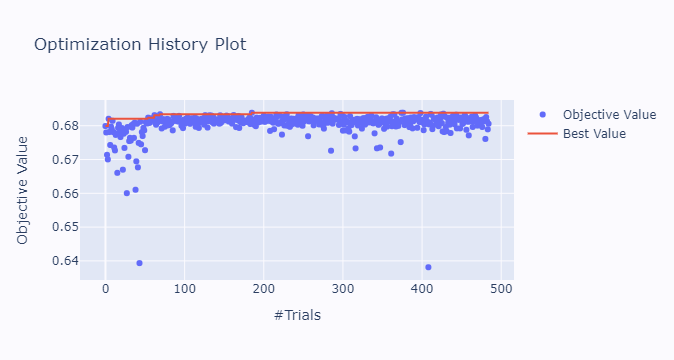

In [45]:
# history
optuna.visualization.plot_optimization_history(study)

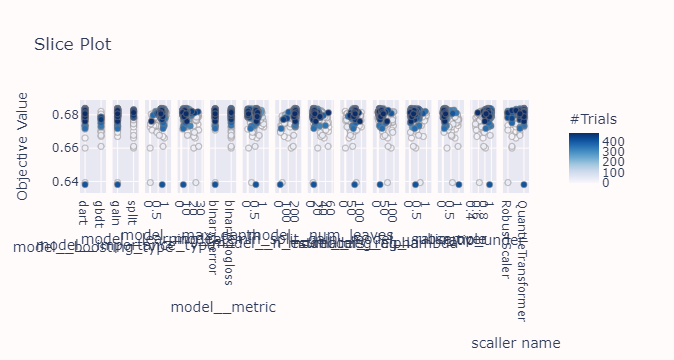

In [46]:
# Visualize individual hyperparameters as slice plot.
optuna.visualization.plot_slice(study)

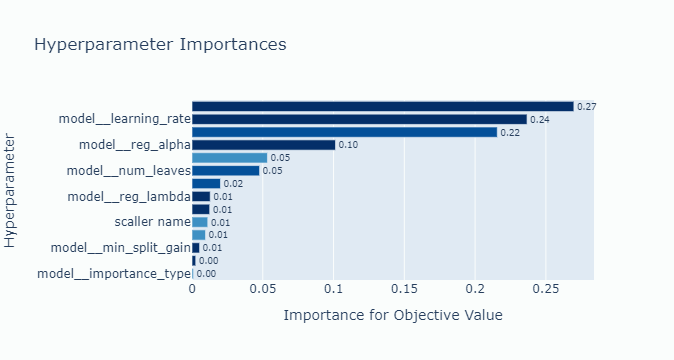

In [47]:
# Visualize parameter importances. 
optuna.visualization.plot_param_importances(study)

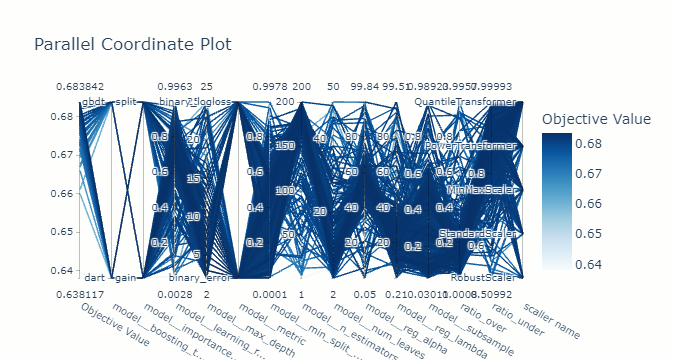

In [48]:
# Space search visualisation
optuna.visualization.plot_parallel_coordinate(study)

In [49]:
# Delete the temporary cache before exiting
# memory.clear(warn=False)
# rmtree(location)

## Meilleure solution

In [50]:
# Load best params from last search from file
# study=joblib.load(file_name)
best = study.best_params

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value: 0.683842054980642
  Params: 
    ratio_over: 0.0811606902694105
    ratio_under: 0.9023419625243958
    scaller name: QuantileTransformer
    model__boosting_type: dart
    model__max_depth: 8
    model__learning_rate: 0.7132707614188026
    model__n_estimators: 185
    model__num_leaves: 4
    model__min_split_gain: 0.5460401638083019
    model__metric: binary_logloss
    model__subsample: 0.08269078501941346
    model__reg_alpha: 63.53249436638803
    model__reg_lambda: 11.075030110904528
    model__importance_type: gain


Class balance on fitting model step : Counter({0: 91840, 1: 13091})
TRAIN
               precision    recall  f1-score   support

           0       0.97      0.72      0.83    122457
           1       0.18      0.73      0.29     10473

    accuracy                           0.72    132930
   macro avg       0.58      0.73      0.56    132930
weighted avg       0.91      0.72      0.78    132930

 Scores  on train : {'COST': 0.6790201483601237, 'AUC': 0.7426266097458148}
TEST
               precision    recall  f1-score   support

           0       0.96      0.72      0.82     30615
           1       0.16      0.63      0.25      2618

    accuracy                           0.71     33233
   macro avg       0.56      0.67      0.54     33233
weighted avg       0.89      0.71      0.78     33233

 Scores  on test : {'COST': 0.6726341973250928}


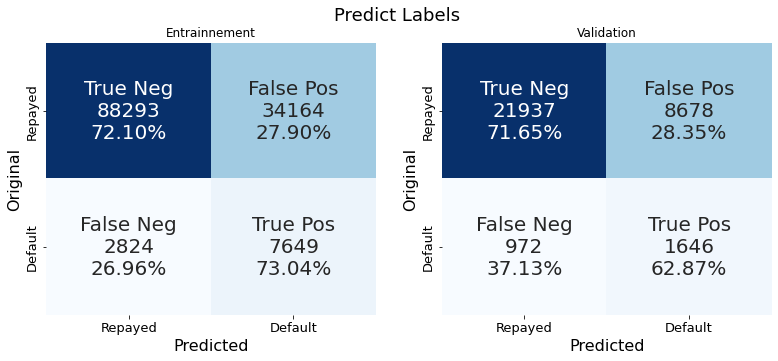

In [51]:
# print best results
# print('Best custom_score = {} for {}'.format(study.best_value,best))

# Initialize params
params = {}


# Variance space
# params['variance__threshold'] = best['variance']

# ratios for samplers
o_r = best['ratio_over']
u_r = best['ratio_under']

#over sampling
params['over__sampling_strategy'] =  ratio_initial *(1 + o_r)

# under sampling
params['under__sampling_strategy'] = ratio_initial *(1 + o_r)/( u_r)
    
# sample weight
# x = best['weight']  # MODIFIE
# params['model__class_weight'] = {0 : 1-x, 1 : x}
params['model__class_weight'] = 'balanced'

# Scaller space
scaler_name = best['scaller name']

if scaler_name == 'MinMaxScaler':
    params['scaler'] = mmx
elif scaler_name == 'StandardScaler':
    params['scaler'] =  std   
elif scaler_name == 'QuantileTransformer':
    params['scaler'] =  qt
elif scaler_name == 'RobustScaler':
    params['scaler'] =  rob
elif scaler_name == 'PowerTransformer':
    params['scaler'] =  pwt  
         
# light Gradient Boosting space       
params['model__boosting_type'] =  best['model__boosting_type']
params['model__max_depth'] =  best['model__max_depth']
params['model__learning_rate'] =  best['model__learning_rate']
params['model__n_estimators'] =  best['model__n_estimators']
# params['model__num_leaves'] =  best['model__num_leaves']
params['model__min_split_gain'] =  best['model__min_split_gain']
params['model__subsample_for_bin'] = 10000
params['model__objective'] = 'binary'
# params['model__early_stopping_rounds'] = 30
params['model__metric'] =  best['model__metric']
params['model__subsample'] =  best['model__subsample']
params['model__reg_alpha'] =  best['model__reg_alpha']
params['model__reg_lambda'] =  best['model__reg_lambda']
params['model__importance_type'] =  best['model__importance_type']


# set and fit with best params
pipe_optim.set_params(**params)
pipe_optim.fit(train, train_true)

# Count effective classes
print('Class balance on fitting model step : %s' % Counter(pipe_samplers[0:2].fit_resample(train,train_true)[1]))
if LOG:
    run['Modele/[Optimisation]/Classe efectives'].log(str(Counter(pipe_samplers[0:2].fit_resample(train,train_true)[1])))


# print evaluation summary
evaluate_estimator(pipe_optim,
                   train,
                   train_true,
                   test,
                   test_true,
                   SCORER,
                   cost,
                   cv,
                   log=(LOG,run,'Modele/[Optimisation]/'))

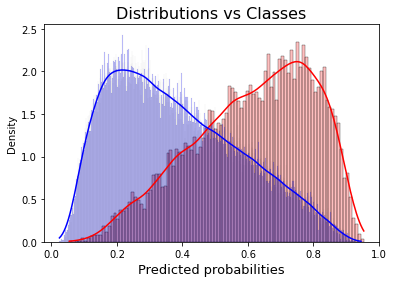

In [52]:
# Distribution of prediction probabilities versus classes
train_predicted_probas = pipe_optim.predict_proba(train)
proba_distributions(train_true,train_predicted_probas,(LOG,run,'Modele/[Optimisation]/Train'))

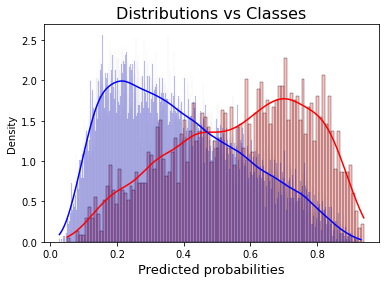

In [53]:
# Distribution of prediction probabilities versus classes
test_predicted_probas = pipe_optim.predict_proba(test)
proba_distributions(test_true,test_predicted_probas,(LOG,run,'Modele/[Optimisation]/Test'))

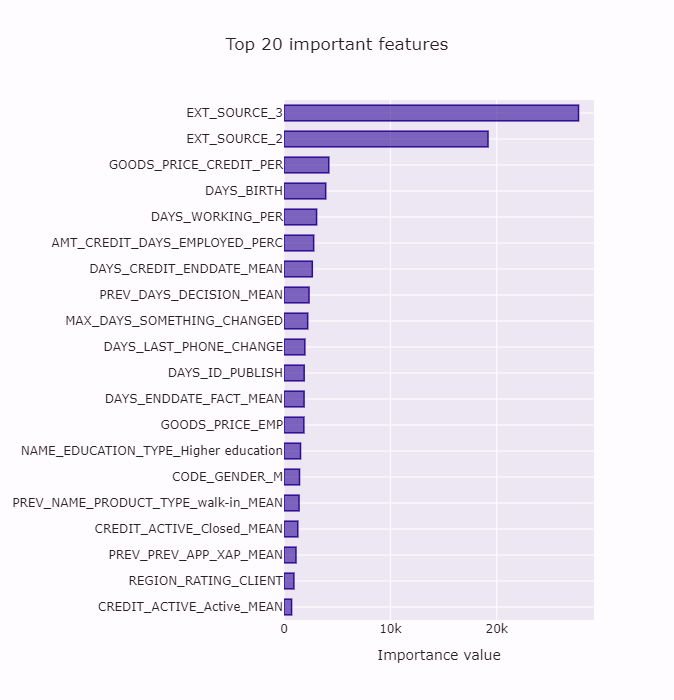

In [54]:
# Feature importance
feature_importance_plot(pipe_optim[-1].feature_importances_,train,(LOG,run,'Modele/[Optimisation]/'))

# Récapitulatif des scores

In [55]:
import ast
# List of all experiment logged to Neptune ai
steps =['[Out of bag]','[Under]','[Over]','[Balance]','[Samplers & Weight]','[Optimisation]']
# create lists to retain fetched logs
train_costs, train_aucs, test_costs, names = list(), list(), list(), list()
# ierate throught logs
for step in steps:
    names.append('LightGradientBoosting '+step)
    train_scores = ast.literal_eval(run['Modele/'+step+'/Train scores'].fetch_last())
    test_score = ast.literal_eval(run['Modele/'+step+'/Test scores'].fetch_last())
    train_costs.append(train_scores['COST'])
    train_aucs.append(train_scores['AUC'])
    test_costs.append(test_score['COST'])

# create results Data Frame
results = pd.DataFrame({'Model name'   : names,
                        'Cost on train': train_costs,
                        'Auc on train' : train_aucs,
                        'Cost on test' : test_costs,
                       }
                      )
joblib.dump(results, 'Results/lgbm.results')
results.style.highlight_max()

,Model name,Cost on train,Auc on train,Cost on test
0,LightGradientBoosting [Out of bag],0.506774,0.741732,0.505300
1,LightGradientBoosting [Under],0.677523,0.739079,0.674390
2,LightGradientBoosting [Over],0.676321,0.739881,0.672065
3,LightGradientBoosting [Balance],0.678217,0.741530,0.675480
4,LightGradientBoosting [Samplers & Weight],0.676258,0.739837,0.672583
5,LightGradientBoosting [Optimisation],0.679020,0.742627,0.672634


# Sauvegarde du modèle pour dasboard

modèle fitté sur toutes les données disponibles

In [56]:
# Set the filename
save_path = 'Models/'
name= 'lgbm_optimized_fitted'
file_name = name+'.mod'

# Fit on whole datas
pipe = clone(pipe_optim)
pipe.fit(features.drop('TARGET', axis=1), features.TARGET)

# Write on disk
joblib.dump(pipe, save_path+file_name, compress=('lzma',3))

if LOG:
    run['Best fitted model on all features jobilb'].upload(File(save_path+file_name))

In [57]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.


All 2 operations synced, thanks for waiting!
